# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [ ]:
# can comment out after executing
!unzip processed_celeba_small.zip

In [1]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [2]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()])
    
    dataset = datasets.ImageFolder(data_dir, transform = transform)

    dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, 
                                            num_workers = 0, shuffle = True)
        
    print(len(dataset))
    return dataloader






## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters

batch_size = 128
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


89931


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

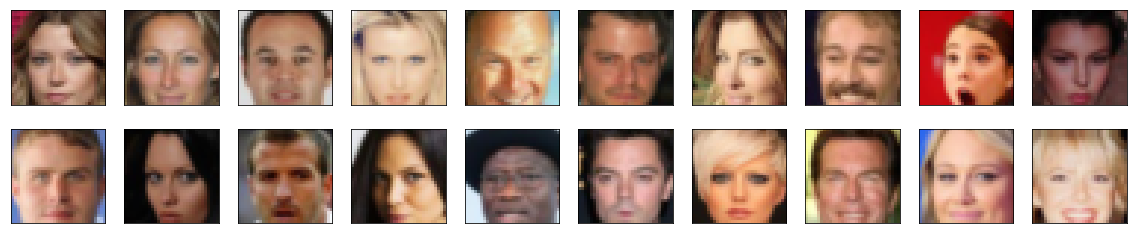

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) - max
    return x


In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print(scaled_img.min(), scaled_img.max())

tensor(-0.9765) tensor(0.7961)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:



class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        k = 4 # kernel size
        s = 2 # stride
        p = 1 # padding
        
        
        # complete init function
        self.conv_dim = conv_dim
        
        self.conv1 = nn.Sequential(nn.Conv2d(3, self.conv_dim, k,s,p, bias = False))

        self.conv2 = nn.Sequential(nn.Conv2d(self.conv_dim, self.conv_dim*2, k,s,p, bias = False), 
                                   nn.BatchNorm2d(self.conv_dim*2)
                                  )
        
        self.conv3 = nn.Sequential(nn.Conv2d(self.conv_dim*2, self.conv_dim*4, k,s,p, bias = False), 
                                   nn.BatchNorm2d(self.conv_dim*4)
                                  )
        
        self.fc = nn.Linear(self.conv_dim*4 * 4 * 4, 1)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x))           
        x = F.leaky_relu(self.conv2(x))           
        x = F.leaky_relu(self.conv3(x))           
        
        x = x.view(-1, self.conv_dim*4 * 4 * 4)   
        x = self.fc(x) 
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


In [11]:
#############################

## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [12]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        
        self.z_size = z_size
        self.conv_dim = conv_dim
        
        k = 4 # kernel size
        s = 2 # stride
        p = 1 # padding
    
        self.fc = nn.Linear(self.z_size, self.conv_dim*4 * 4 * 4) 
        
        # complete init funtion
        self.deconv1 = nn.Sequential(nn.ConvTranspose2d(self.conv_dim*4, self.conv_dim*2, k,s,p, bias = False), 
                                     nn.BatchNorm2d(self.conv_dim*2)
                                    )
        self.deconv2 = nn.Sequential(nn.ConvTranspose2d(self.conv_dim*2, self.conv_dim , k,s,p, bias = False), 
                                     nn.BatchNorm2d(self.conv_dim)
                                    )
        self.deconv3 = nn.Sequential(nn.ConvTranspose2d(self.conv_dim, 3, k,s,p, bias = False))
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        
        x = self.fc(x)
        
        x = x.view(-1, self.conv_dim*4, 4, 4)
        
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.tanh(self.deconv3(x))
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [13]:
from torch.nn import init

def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers

    if hasattr(m, 'weight'):
        if classname.find('Conv') != -1 or classname.find('Linear') != -1:
            init.normal_(m.weight.data, 0.0, 0.02)
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [15]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [17]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    loss = torch.mean((D_out - 0.9)**2)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    loss = torch.mean((D_out)**2)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [18]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G



lr, b1, b2 = 0.0002, 0.5, 0.999

d_optimizer = optim.Adam(D.parameters(), lr, [b1, b2])
g_optimizer = optim.Adam(G.parameters(), lr, [b1, b2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [19]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            
            # 1. Train the discriminator on real and fake images
            
            d_optimizer.zero_grad()
            
            d_loss_real = real_loss(D(real_images.cuda()))
            
            z = np.random.uniform(-1, 1, size = (batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            
            fake_images = G(z)
            d_loss_fake = fake_loss(D(fake_images))
            
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            d_optimizer.step()

            
            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            z = np.random.uniform(-1, 1, size = (batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            g_loss = real_loss(D(fake_images))
            g_loss.backward()
            g_optimizer.step()
            
            
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [20]:
# set number of epochs 
n_epochs = 10


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   10] | d_loss: 0.9957 | g_loss: 0.4853
Epoch [    1/   10] | d_loss: 0.0978 | g_loss: 1.2751
Epoch [    1/   10] | d_loss: 0.0453 | g_loss: 1.2377
Epoch [    1/   10] | d_loss: 0.0427 | g_loss: 0.8464
Epoch [    1/   10] | d_loss: 0.0309 | g_loss: 0.8376
Epoch [    1/   10] | d_loss: 0.0922 | g_loss: 0.9517
Epoch [    1/   10] | d_loss: 0.0351 | g_loss: 0.7176
Epoch [    1/   10] | d_loss: 0.0774 | g_loss: 0.5169
Epoch [    1/   10] | d_loss: 0.0477 | g_loss: 0.6253
Epoch [    1/   10] | d_loss: 0.0549 | g_loss: 0.7484
Epoch [    1/   10] | d_loss: 0.2078 | g_loss: 0.7640
Epoch [    1/   10] | d_loss: 0.4281 | g_loss: 0.9411
Epoch [    1/   10] | d_loss: 0.2012 | g_loss: 0.5072
Epoch [    1/   10] | d_loss: 0.5358 | g_loss: 0.8911
Epoch [    1/   10] | d_loss: 0.1619 | g_loss: 0.4403
Epoch [    2/   10] | d_loss: 0.1056 | g_loss: 0.6778
Epoch [    2/   10] | d_loss: 0.2322 | g_loss: 0.3644
Epoch [    2/   10] | d_loss: 0.1384 | g_loss: 0.5369
Epoch [    2/   10] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

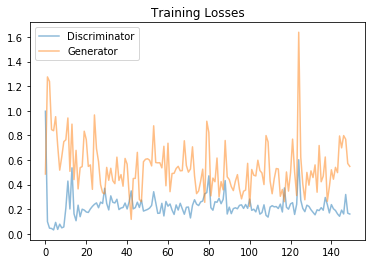

In [21]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [22]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [23]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

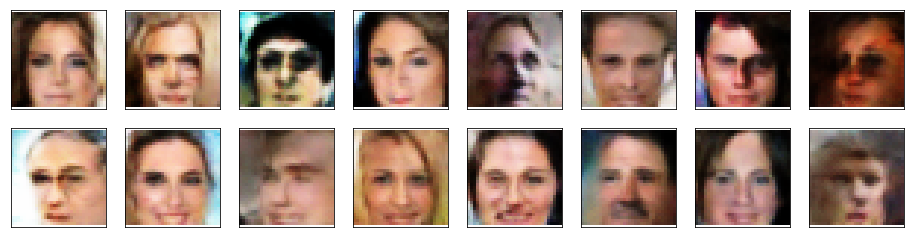

In [24]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

The generated images are quite "sketchy", some of them are really like from a horror movie. The images might be biased as the celebrity faces are mostly white, but also biased by the mixture of male and female faces. The facial features and accessories (glasses, make-up) might influence the results as well.


I think that the the noise in the resulted images comes primarily from the diversity of the images in the dataset (face positions, orientation, gender, accessories, etc.) and not from the low resolution of the images in the training dataset.

Hyper-parameter tuning did produce better results (optically pleasing at least), however, it did not solve the morphing (scary-ness) of the generated faces.

I experimented with 3 and 4 convolutional layer discriminator and generator networks. The batch size apeared to have a significant impact on the obtained results. In the case of 4 conv layers, it was difficult to obtain results that were as good as the results from 3 conv layers. 

I think the easiest way to improve the results is to use some kind of training image filtering, where similar faces would be grouped - when the facial features are alike, I would expect better results in comparison when the training dataset contains diverse "faces".

In order to improve the network models "performance" (i.e. to produce more human looking faces) first the increase of epoch number would be beneficial. Deeper network might recognize more features, but this would be useful if the resolution of the images would be high enough.

-


Epoch [    1/   30] | d_loss: 0.1549 | g_loss: 0.5668
Epoch [    1/   30] | d_loss: 0.1947 | g_loss: 0.4841
Epoch [    1/   30] | d_loss: 0.0892 | g_loss: 0.4743
Epoch [    1/   30] | d_loss: 0.2288 | g_loss: 0.7715
Epoch [    1/   30] | d_loss: 0.3124 | g_loss: 0.1098
Epoch [    1/   30] | d_loss: 0.2032 | g_loss: 0.5275
Epoch [    1/   30] | d_loss: 0.2310 | g_loss: 0.4246
Epoch [    1/   30] | d_loss: 0.1968 | g_loss: 0.4912
Epoch [    1/   30] | d_loss: 0.1792 | g_loss: 0.5839
Epoch [    1/   30] | d_loss: 0.1597 | g_loss: 0.5380
Epoch [    1/   30] | d_loss: 0.1388 | g_loss: 0.6562
Epoch [    1/   30] | d_loss: 0.1765 | g_loss: 0.5066
Epoch [    1/   30] | d_loss: 0.2092 | g_loss: 0.5499
Epoch [    1/   30] | d_loss: 0.1547 | g_loss: 0.4254
Epoch [    1/   30] | d_loss: 0.1227 | g_loss: 0.3318
Epoch [    2/   30] | d_loss: 0.2114 | g_loss: 0.2983
Epoch [    2/   30] | d_loss: 0.1944 | g_loss: 0.3199
Epoch [    2/   30] | d_loss: 0.1747 | g_loss: 0.5107
Epoch [    2/   30] | d_loss

Epoch [   11/   30] | d_loss: 0.2371 | g_loss: 0.3693
Epoch [   11/   30] | d_loss: 0.1543 | g_loss: 0.4217
Epoch [   11/   30] | d_loss: 0.1150 | g_loss: 0.4899
Epoch [   11/   30] | d_loss: 0.2641 | g_loss: 0.3409
Epoch [   11/   30] | d_loss: 0.1355 | g_loss: 0.7718
Epoch [   11/   30] | d_loss: 0.1448 | g_loss: 0.4796
Epoch [   11/   30] | d_loss: 0.1471 | g_loss: 0.5398
Epoch [   11/   30] | d_loss: 0.0859 | g_loss: 0.5840
Epoch [   11/   30] | d_loss: 0.2009 | g_loss: 0.2959
Epoch [   11/   30] | d_loss: 0.1420 | g_loss: 0.4523
Epoch [   11/   30] | d_loss: 0.1546 | g_loss: 0.6977
Epoch [   11/   30] | d_loss: 0.1073 | g_loss: 0.4471
Epoch [   11/   30] | d_loss: 0.1095 | g_loss: 0.6305
Epoch [   12/   30] | d_loss: 0.0879 | g_loss: 0.6320
Epoch [   12/   30] | d_loss: 0.4024 | g_loss: 0.1347
Epoch [   12/   30] | d_loss: 0.1478 | g_loss: 0.6264
Epoch [   12/   30] | d_loss: 0.1820 | g_loss: 0.6876
Epoch [   12/   30] | d_loss: 0.1311 | g_loss: 0.6323
Epoch [   12/   30] | d_loss

Epoch [   21/   30] | d_loss: 0.1653 | g_loss: 1.1586
Epoch [   21/   30] | d_loss: 0.1498 | g_loss: 0.9654
Epoch [   21/   30] | d_loss: 0.4184 | g_loss: 1.1280
Epoch [   21/   30] | d_loss: 0.0951 | g_loss: 0.4953
Epoch [   21/   30] | d_loss: 0.0637 | g_loss: 0.5534
Epoch [   21/   30] | d_loss: 0.2311 | g_loss: 0.5963
Epoch [   21/   30] | d_loss: 0.0566 | g_loss: 0.6899
Epoch [   21/   30] | d_loss: 0.1091 | g_loss: 0.8028
Epoch [   21/   30] | d_loss: 0.1120 | g_loss: 0.6212
Epoch [   21/   30] | d_loss: 0.1167 | g_loss: 0.5942
Epoch [   21/   30] | d_loss: 0.0919 | g_loss: 0.6870
Epoch [   22/   30] | d_loss: 0.1155 | g_loss: 0.7880
Epoch [   22/   30] | d_loss: 0.1061 | g_loss: 0.8008
Epoch [   22/   30] | d_loss: 0.0809 | g_loss: 0.7295
Epoch [   22/   30] | d_loss: 0.0850 | g_loss: 0.6843
Epoch [   22/   30] | d_loss: 0.2133 | g_loss: 0.3349
Epoch [   22/   30] | d_loss: 0.5515 | g_loss: 0.1068
Epoch [   22/   30] | d_loss: 0.1309 | g_loss: 0.7475
Epoch [   22/   30] | d_loss

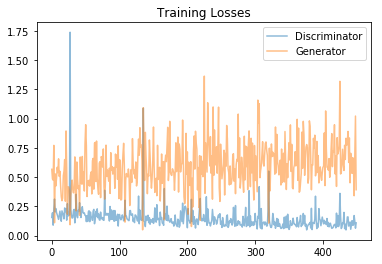

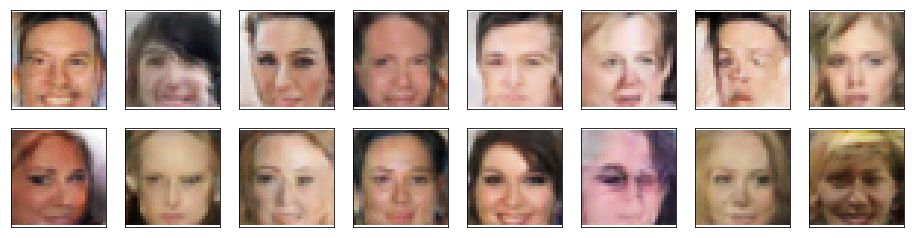

In [30]:
# set number of epochs 
n_epochs = 30


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
    
_ = view_samples(-1, samples)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.

In [31]:


# In the following lines I experiment with different hyperparameter values and image sizes



In [10]:
#######

# to run inside the DLND workspace
#######


# !unzip processed_celeba_small.zip

data_dir = 'processed_celeba_small/'


import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
import torch
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torch.optim as optim


def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()])
    dataset = datasets.ImageFolder(data_dir, transform = transform)
    print('Number of images: ', len(dataset))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, 
                                            num_workers = 0, shuffle = True)
    
    return dataloader

def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max-min) - max
    return x


def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
#    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
#        init.normal_(m.weight.data, 0.0, 0.02)
    if hasattr(m, 'weight'):
        if classname.find('Conv') != -1 or classname.find('Linear') != -1:
            init.normal_(m.weight.data, 0.0, 0.02)


# define the loss
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    loss = torch.mean((D_out - 0.9)**2)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    loss = torch.mean((D_out)**2)
    return loss



# Define the model
# 1- Discriminator

class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        self.conv1 = nn.Sequential(nn.Conv2d(3, self.conv_dim, 4,2,1, bias = False))

        self.conv2 = nn.Sequential(nn.Conv2d(self.conv_dim, self.conv_dim*2, 4,2,1, bias = False), 
                                   nn.BatchNorm2d(self.conv_dim*2)
                                  )
        
        self.conv3 = nn.Sequential(nn.Conv2d(self.conv_dim*2, self.conv_dim*4, 4,2,1, bias = False), 
                                   nn.BatchNorm2d(self.conv_dim*4)
                                  )
        
        self.fc = nn.Linear(self.conv_dim*4 * 4 * 4, 1)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x))           
        x = F.leaky_relu(self.conv2(x))           
        x = F.leaky_relu(self.conv3(x))           
        
        x = x.view(-1, self.conv_dim*4 * 4 * 4)   
        x = self.fc(x) # (128, 1, 1)
        return x

# 2 - Generator
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        
        self.z_size = z_size
        self.conv_dim = conv_dim
    
    
        self.fc = nn.Linear(self.z_size, 4 * 4 * self.conv_dim * 4) 
        
        # complete init funtion
        self.deconv1 = nn.Sequential(nn.ConvTranspose2d(self.conv_dim*4, self.conv_dim*2, 4, 2, 1, bias = False), 
                                     nn.BatchNorm2d(self.conv_dim*2)
                                    )
        self.deconv2 = nn.Sequential(nn.ConvTranspose2d(self.conv_dim*2, self.conv_dim ,4, 2, 1, bias = False), 
                                     nn.BatchNorm2d(self.conv_dim)
                                    )
        self.deconv3 = nn.Sequential(nn.ConvTranspose2d(self.conv_dim, 3, 4, 2, 1, bias = False))
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        
        x = self.fc(x)
        
        x = x.view(-1, self.conv_dim*4, 4, 4)
        
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.tanh(self.deconv3(x))
        
        return x

# Build the Network
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


# training function
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    
    sample_size=16
    
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            
            # 1. Train the discriminator on real and fake images
            
            d_optimizer.zero_grad()
            
            d_loss_real = real_loss(D(real_images.cuda()))
            
            z = np.random.uniform(-1, 1, size = (batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            
            fake_images = G(z)
            d_loss_fake = fake_loss(D(fake_images))
            
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            d_optimizer.step()

            
            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            z = np.random.uniform(-1, 1, size = (batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            g_loss = real_loss(D(fake_images))
            g_loss.backward()
            g_optimizer.step()
            
            
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses


def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))


# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')


# Define function hyperparameters

batch_size = 128
img_size = 32 #32 #32

# Define model hyperparams
d_conv_dim =98 #64  #32
g_conv_dim =98 # 64 #32
z_size = 100

lr, b1, b2 = 0.0002, 0.5, 0.999

# set number of epochs 
n_epochs = 20
   


# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)    

D, G = build_network(d_conv_dim, g_conv_dim, z_size)
    
d_optimizer = optim.Adam(D.parameters(), lr, [b1, b2])
g_optimizer = optim.Adam(G.parameters(), lr, [b1, b2])
# call training function
losses = train(D, G, n_epochs=n_epochs)





Training on GPU!
Number of images:  89931
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 98, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(98, 196, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(196, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(196, 392, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=6272, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=6272, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(392, 196, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(196, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(196, 98, kernel_

KeyboardInterrupt: 

In [2]:
#


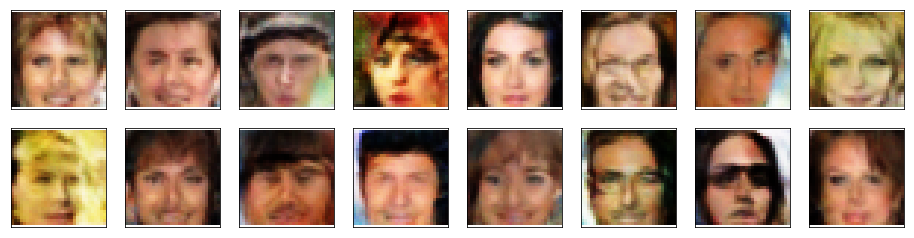

In [3]:
# image size 32x32 
# 10 epochs
# d_conv_dim, g_conv_dim = 32,32

with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples(-1, samples)

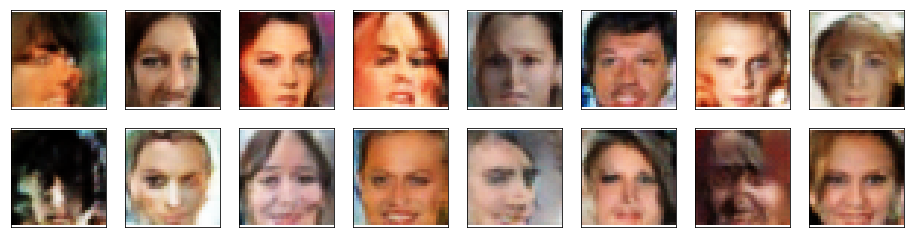

In [16]:
# image size 32x32
# 10 epochs
# d_conv_dim, g_conv_dim = 64,64

with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples(-1, samples)

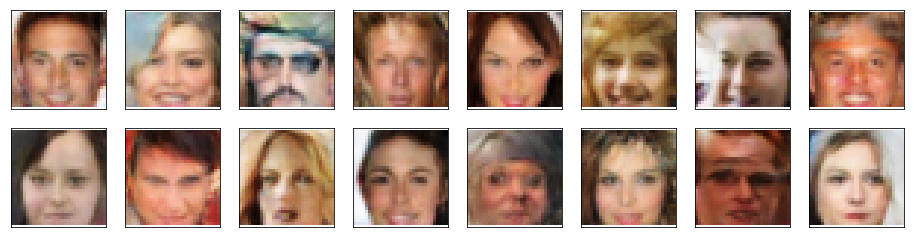

In [5]:
# image size 32x32
# 20 epochs
# d_conv_dim, g_conv_dim = 64,64

with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples(-1, samples)

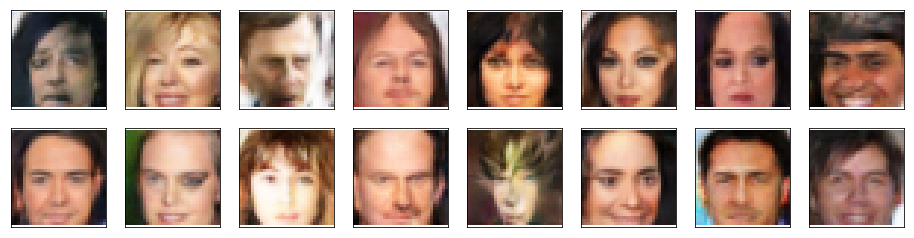

In [7]:
# image size 32x32
# 20 epochs
# d_conv_dim, g_conv_dim = 98,98

with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples(-1, samples)

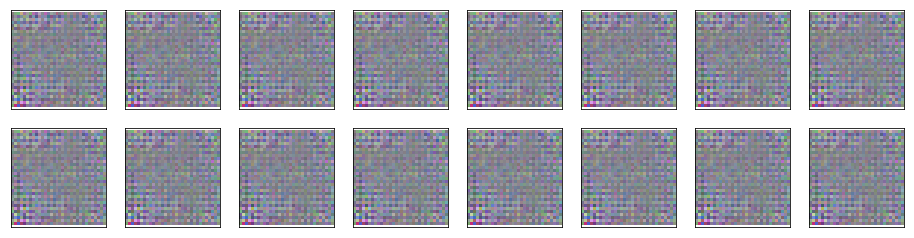

In [6]:
# just to try what does it look like to take a bigger image size 

# image size 64x64
# 10 epochs
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples(-1, samples)

___
## 4 convolutional layers in the Discriminator and Generator 



In [5]:
#######

# to run inside the DLND workspace
#######


# !unzip processed_celeba_small.zip

data_dir = 'processed_celeba_small/'


import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
import torch
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torch.optim as optim


def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()])
    dataset = datasets.ImageFolder(data_dir, transform = transform)
    print('Number of images: ', len(dataset))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, 
                                            num_workers = 0, shuffle = True)
    
    return dataloader

def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max-min) - max
    return x


def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
#    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
#        init.normal_(m.weight.data, 0.0, 0.02)
    if hasattr(m, 'weight'):
        if classname.find('Conv') != -1 or classname.find('Linear') != -1:
            init.normal_(m.weight.data, 0.0, 0.02)


# define the loss
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    loss = torch.mean((D_out - 0.9)**2)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    loss = torch.mean((D_out)**2)
    return loss



# Define the model
# 1- Discriminator

class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        k = 4 # kernel size
        s = 2 # stride
        p = 1 # padding
        
        self.conv1 = nn.Sequential(nn.Conv2d(3, self.conv_dim,  k,s,p, bias = False))

        self.conv2 = nn.Sequential(nn.Conv2d(self.conv_dim, self.conv_dim*2, k,s,p, bias = False), 
                                   nn.BatchNorm2d(self.conv_dim*2))
        
        self.conv3 = nn.Sequential(nn.Conv2d(self.conv_dim*2, self.conv_dim*4,  k,s,p, bias = False), 
                                   nn.BatchNorm2d(self.conv_dim*4))
        
        self.conv4 = nn.Sequential(nn.Conv2d(self.conv_dim*4, self.conv_dim*8,  k,s,p, bias = False), 
                                   nn.BatchNorm2d(self.conv_dim*8))

        
        self.fc = nn.Linear(self.conv_dim*8 * 2 * 2 , 1)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """

        x = F.leaky_relu(self.conv1(x))         
        x = F.leaky_relu(self.conv2(x))        
        x = F.leaky_relu(self.conv3(x))        
        x = F.leaky_relu(self.conv4(x))        
        
        
        x = x.view(-1, self.conv_dim *8 * 2 * 2 )
        return x

# 2 - Generator
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        
        self.z_size = z_size
        self.conv_dim = conv_dim
        
        k = 4 # kernel size
        s = 2 # stride
        p = 1 # padding
    
        self.fc = nn.Linear(self.z_size,  self.conv_dim*8 * 2 * 2) 
        
        # complete init funtion
        self.deconv1 = nn.Sequential(nn.ConvTranspose2d(self.conv_dim*8, self.conv_dim*4, k,s,p, bias = False), 
                                     nn.BatchNorm2d(self.conv_dim*4))
        self.deconv2 = nn.Sequential(nn.ConvTranspose2d(self.conv_dim*4, self.conv_dim*2, k,s,p, bias = False), 
                                     nn.BatchNorm2d(self.conv_dim*2))
        self.deconv3 = nn.Sequential(nn.ConvTranspose2d(self.conv_dim*2, self.conv_dim , k,s,p, bias = False), 
                                     nn.BatchNorm2d(self.conv_dim))
        self.deconv4 = nn.Sequential(nn.ConvTranspose2d(self.conv_dim, 3, k,s,p, bias = False))
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        
        x = self.fc(x)
        
        x = x.view(-1, self.conv_dim*8 , 2, 2)
        
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.tanh(self.deconv3(x))
        x = F.tanh(self.deconv4(x))
        
        return x

    
    
# Build the Network
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


# training function
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    
    sample_size=16
    
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            
            # 1. Train the discriminator on real and fake images
            
            d_optimizer.zero_grad()
            
            d_loss_real = real_loss(D(real_images.cuda()))
            
            z = np.random.uniform(-1, 1, size = (batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            
            fake_images = G(z)
            d_loss_fake = fake_loss(D(fake_images))
            
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            d_optimizer.step()

            
            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            z = np.random.uniform(-1, 1, size = (batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            g_loss = real_loss(D(fake_images))
            g_loss.backward()
            g_optimizer.step()
            
            
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses


def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))


# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')


# Define function hyperparameters

batch_size = 128 #64 #256 #128
img_size = 32 #32

# Define model hyperparams
d_conv_dim = 32  #32
g_conv_dim = 32 #32
z_size = 100

lr, b1, b2 = 0.0002, 0.5, 0.999

# set number of epochs 
n_epochs = 10
   


# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)    

D, G = build_network(d_conv_dim, g_conv_dim, z_size)
    
d_optimizer = optim.Adam(D.parameters(), lr, [b1, b2])
g_optimizer = optim.Adam(G.parameters(), lr, [b1, b2])
# call training function
losses = train(D, G, n_epochs=n_epochs)



Training on GPU!
Number of images:  89931
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=1024, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=1024, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), 

Epoch [    9/   10] | d_loss: 0.4765 | g_loss: 0.4420
Epoch [    9/   10] | d_loss: 0.4755 | g_loss: 0.4415
Epoch [    9/   10] | d_loss: 0.4743 | g_loss: 0.4410
Epoch [    9/   10] | d_loss: 0.4729 | g_loss: 0.4405
Epoch [    9/   10] | d_loss: 0.4718 | g_loss: 0.4402
Epoch [    9/   10] | d_loss: 0.4709 | g_loss: 0.4398
Epoch [    9/   10] | d_loss: 0.4696 | g_loss: 0.4391
Epoch [    9/   10] | d_loss: 0.4689 | g_loss: 0.4392
Epoch [    9/   10] | d_loss: 0.4683 | g_loss: 0.4395
Epoch [    9/   10] | d_loss: 0.4678 | g_loss: 0.4398
Epoch [    9/   10] | d_loss: 0.4666 | g_loss: 0.4397
Epoch [    9/   10] | d_loss: 0.4659 | g_loss: 0.4397
Epoch [    9/   10] | d_loss: 0.4646 | g_loss: 0.4391
Epoch [    9/   10] | d_loss: 0.4639 | g_loss: 0.4391
Epoch [   10/   10] | d_loss: 0.4639 | g_loss: 0.4391
Epoch [   10/   10] | d_loss: 0.4629 | g_loss: 0.4387
Epoch [   10/   10] | d_loss: 0.4613 | g_loss: 0.4381
Epoch [   10/   10] | d_loss: 0.4598 | g_loss: 0.4371
Epoch [   10/   10] | d_loss

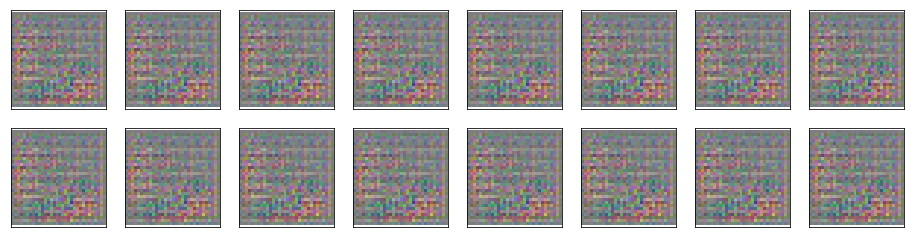

In [6]:
# image size 32x32
# 10 epochs
# d_conv_dim, g_conv_dim = 32,32

with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples(-1, samples)

In [9]:
#######
#
# Implement the entire code in a single function and pass the hyperparameters into it
# (use only in jupyter notebooks workspace)
#
#######
data_dir = 'processed_celeba_small/'


import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
import torch
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torch.optim as optim


def run_all(batch_size = 128, img_size = 32, 
	d_conv_dim = 32 ,
	g_conv_dim = 32,
	z_size = 100,
	lr = 0.0002, b1=0.5, b2=0.999,
	n_epochs = 10):

	def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
		"""
		Batch the neural network data using DataLoader
		:param batch_size: The size of each batch; the number of images in a batch
		:param img_size: The square size of the image data (x, y)
		:param data_dir: Directory where image data is located
		:return: DataLoader with batched data
		"""
		
		# TODO: Implement function and return a dataloader
		
		transform = transforms.Compose([transforms.Resize(image_size),
										transforms.ToTensor()])
		dataset = datasets.ImageFolder(data_dir, transform = transform)
		print('Number of images: ', len(dataset))
		dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, 
												num_workers = 0, shuffle = True)
		
		return dataloader

	def scale(x, feature_range=(-1, 1)):
		''' Scale takes in an image x and returns that image, scaled
		   with a feature_range of pixel values from -1 to 1. 
		   This function assumes that the input x is already scaled from 0-1.'''
		# assume x is scaled to (0, 1)
		# scale to feature_range and return scaled x
		min, max = feature_range
		x = x * (max-min) - max
		return x


	def weights_init_normal(m):
		"""
		Applies initial weights to certain layers in a model .
		The weights are taken from a normal distribution 
		with mean = 0, std dev = 0.02.
		:param m: A module or layer in a network    
		"""
		# classname will be something like:
		# `Conv`, `BatchNorm2d`, `Linear`, etc.
		classname = m.__class__.__name__
		
		# TODO: Apply initial weights to convolutional and linear layers
	#    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
	#        init.normal_(m.weight.data, 0.0, 0.02)
		if hasattr(m, 'weight'):
			if classname.find('Conv') != -1 or classname.find('Linear') != -1:
				init.normal_(m.weight.data, 0.0, 0.02)


	# define the loss
	def real_loss(D_out):
		'''Calculates how close discriminator outputs are to being real.
		   param, D_out: discriminator logits
		   return: real loss'''
		loss = torch.mean((D_out - 0.9)**2)
		return loss

	def fake_loss(D_out):
		'''Calculates how close discriminator outputs are to being fake.
		   param, D_out: discriminator logits
		   return: fake loss'''
		loss = torch.mean((D_out)**2)
		return loss



	# Define the model
	# 1- Discriminator

	class Discriminator(nn.Module):

		def __init__(self, conv_dim):
			"""
			Initialize the Discriminator Module
			:param conv_dim: The depth of the first convolutional layer
			"""
			super(Discriminator, self).__init__()

			# complete init function
			self.conv_dim = conv_dim
			
			k = 4 # kernel size
			s = 2 # stride
			p = 1 # padding
			
			self.conv1 = nn.Sequential(nn.Conv2d(3, self.conv_dim,  k,s,p, bias = False))

			self.conv2 = nn.Sequential(nn.Conv2d(self.conv_dim, self.conv_dim*2, k,s,p, bias = False), 
									   nn.BatchNorm2d(self.conv_dim*2))
			
			self.conv3 = nn.Sequential(nn.Conv2d(self.conv_dim*2, self.conv_dim*4,  k,s,p, bias = False), 
									   nn.BatchNorm2d(self.conv_dim*4))
			
			self.conv4 = nn.Sequential(nn.Conv2d(self.conv_dim*4, self.conv_dim*8,  k,s,p, bias = False), 
									   nn.BatchNorm2d(self.conv_dim*8))

			
			self.fc = nn.Linear(self.conv_dim*8 * 2 * 2 , 1)
			

		def forward(self, x):
			"""
			Forward propagation of the neural network
			:param x: The input to the neural network     
			:return: Discriminator logits; the output of the neural network
			"""

			x = F.leaky_relu(self.conv1(x))         
			x = F.leaky_relu(self.conv2(x))        
			x = F.leaky_relu(self.conv3(x))        
			x = F.leaky_relu(self.conv4(x))        
			
			
			x = x.view(-1, self.conv_dim *8 * 2 * 2 )
			return x

	# 2 - Generator
	class Generator(nn.Module):
		
		def __init__(self, z_size, conv_dim):
			"""
			Initialize the Generator Module
			:param z_size: The length of the input latent vector, z
			:param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
			"""
			super(Generator, self).__init__()
			
			self.z_size = z_size
			self.conv_dim = conv_dim
			
			k = 4 # kernel size
			s = 2 # stride
			p = 1 # padding
		
			self.fc = nn.Linear(self.z_size,  self.conv_dim*8 * 2 * 2) 
			
			# complete init funtion
			self.deconv1 = nn.Sequential(nn.ConvTranspose2d(self.conv_dim*8, self.conv_dim*4, k,s,p, bias = False), 
										 nn.BatchNorm2d(self.conv_dim*4))
			self.deconv2 = nn.Sequential(nn.ConvTranspose2d(self.conv_dim*4, self.conv_dim*2, k,s,p, bias = False), 
										 nn.BatchNorm2d(self.conv_dim*2))
			self.deconv3 = nn.Sequential(nn.ConvTranspose2d(self.conv_dim*2, self.conv_dim , k,s,p, bias = False), 
										 nn.BatchNorm2d(self.conv_dim))
			self.deconv4 = nn.Sequential(nn.ConvTranspose2d(self.conv_dim, 3, k,s,p, bias = False))
			

		def forward(self, x):
			"""
			Forward propagation of the neural network
			:param x: The input to the neural network     
			:return: A 32x32x3 Tensor image as output
			"""
			# define feedforward behavior
			
			x = self.fc(x)
			
			x = x.view(-1, self.conv_dim*8 , 2, 2)
			
			x = F.relu(self.deconv1(x))
			x = F.relu(self.deconv2(x))
			x = F.tanh(self.deconv3(x))
			x = F.tanh(self.deconv4(x))
			
			return x

		
		
	# Build the Network
	def build_network(d_conv_dim, g_conv_dim, z_size):
		# define discriminator and generator
		D = Discriminator(d_conv_dim)
		G = Generator(z_size=z_size, conv_dim=g_conv_dim)

		# initialize model weights
		D.apply(weights_init_normal)
		G.apply(weights_init_normal)

		print(D)
		print()
		print(G)
		
		return D, G


	# training function
	def train(D, G, n_epochs, print_every=50):
		'''Trains adversarial networks for some number of epochs
		   param, D: the discriminator network
		   param, G: the generator network
		   param, n_epochs: number of epochs to train for
		   param, print_every: when to print and record the models' losses
		   return: D and G losses'''
		
		# move models to GPU
		if train_on_gpu:
			D.cuda()
			G.cuda()

		# keep track of loss and generated, "fake" samples
		samples = []
		losses = []

		# Get some fixed data for sampling. These are images that are held
		# constant throughout training, and allow us to inspect the model's performance
		
		sample_size=16
		
		fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
		fixed_z = torch.from_numpy(fixed_z).float()
		# move z to GPU if available
		if train_on_gpu:
			fixed_z = fixed_z.cuda()

		# epoch training loop
		for epoch in range(n_epochs):

			# batch training loop
			for batch_i, (real_images, _) in enumerate(celeba_train_loader):

				batch_size = real_images.size(0)
				real_images = scale(real_images)

				# ===============================================
				#         YOUR CODE HERE: TRAIN THE NETWORKS
				# ===============================================
				
				
				# 1. Train the discriminator on real and fake images
				
				d_optimizer.zero_grad()
				
				d_loss_real = real_loss(D(real_images.cuda()))
				
				z = np.random.uniform(-1, 1, size = (batch_size, z_size))
				z = torch.from_numpy(z).float()
				
				if train_on_gpu:
					z = z.cuda()
				
				fake_images = G(z)
				d_loss_fake = fake_loss(D(fake_images))
				
				d_loss = d_loss_real + d_loss_fake
				d_loss.backward()
				d_optimizer.step()

				
				# 2. Train the generator with an adversarial loss
				g_optimizer.zero_grad()
				
				z = np.random.uniform(-1, 1, size = (batch_size, z_size))
				z = torch.from_numpy(z).float()
				
				if train_on_gpu:
					z = z.cuda()
				fake_images = G(z)
				
				g_loss = real_loss(D(fake_images))
				g_loss.backward()
				g_optimizer.step()
				
				
				
				
				# ===============================================
				#              END OF YOUR CODE
				# ===============================================

				# Print some loss stats
				if batch_i % print_every == 0:
					# append discriminator loss and generator loss
					losses.append((d_loss.item(), g_loss.item()))
					# print discriminator and generator loss
					print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
							epoch+1, n_epochs, d_loss.item(), g_loss.item()))


			## AFTER EACH EPOCH##    
			# this code assumes your generator is named G, feel free to change the name
			# generate and save sample, fake images
			G.eval() # for generating samples
			samples_z = G(fixed_z)
			samples.append(samples_z)
			G.train() # back to training mode

		# Save training generator samples
		with open('train_samples.pkl', 'wb') as f:
			pkl.dump(samples, f)
		
		# finally return losses
		return losses


	def view_samples(epoch, samples):
		fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
		for ax, img in zip(axes.flatten(), samples[epoch]):
			img = img.detach().cpu().numpy()
			img = np.transpose(img, (1, 2, 0))
			img = ((img + 1)*255 / (2)).astype(np.uint8)
			ax.xaxis.set_visible(False)
			ax.yaxis.set_visible(False)
			im = ax.imshow(img.reshape((32,32,3)))


	# Check for a GPU
	train_on_gpu = torch.cuda.is_available()
	if not train_on_gpu:
		print('No GPU found. Please use a GPU to train your neural network.')
	else:
		print('Training on GPU!')


	# Define function hyperparameters 


	# Call your function and get a dataloader
	celeba_train_loader = get_dataloader(batch_size, img_size)    

	D, G = build_network(d_conv_dim, g_conv_dim, z_size)
		
	d_optimizer = optim.Adam(D.parameters(), lr, [b1, b2])
	g_optimizer = optim.Adam(G.parameters(), lr, [b1, b2])
	# call training function
	losses = train(D, G, n_epochs=n_epochs)

	with open('train_samples.pkl', 'rb') as f:
		samples = pkl.load(f)
	_ = view_samples(-1, samples)


Training on GPU!
Number of images:  89931
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=1024, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=1024, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), 

Epoch [    5/   20] | d_loss: 0.4427 | g_loss: 0.3876
Epoch [    5/   20] | d_loss: 0.4412 | g_loss: 0.3877
Epoch [    5/   20] | d_loss: 0.4442 | g_loss: 0.3715
Epoch [    5/   20] | d_loss: 0.4572 | g_loss: 0.3557
Epoch [    5/   20] | d_loss: 0.4529 | g_loss: 0.3575
Epoch [    5/   20] | d_loss: 0.4505 | g_loss: 0.3718
Epoch [    5/   20] | d_loss: 0.4471 | g_loss: 0.3812
Epoch [    5/   20] | d_loss: 0.4520 | g_loss: 0.3479
Epoch [    5/   20] | d_loss: 0.4525 | g_loss: 0.3655
Epoch [    5/   20] | d_loss: 0.4409 | g_loss: 0.3830
Epoch [    5/   20] | d_loss: 0.4388 | g_loss: 0.3684
Epoch [    5/   20] | d_loss: 0.4455 | g_loss: 0.3731
Epoch [    5/   20] | d_loss: 0.4481 | g_loss: 0.3952
Epoch [    5/   20] | d_loss: 0.4560 | g_loss: 0.3742
Epoch [    5/   20] | d_loss: 0.4412 | g_loss: 0.3740
Epoch [    5/   20] | d_loss: 0.4426 | g_loss: 0.3535
Epoch [    5/   20] | d_loss: 0.4446 | g_loss: 0.3399
Epoch [    5/   20] | d_loss: 0.4534 | g_loss: 0.3920
Epoch [    5/   20] | d_loss

Epoch [   10/   20] | d_loss: 0.3992 | g_loss: 0.3740
Epoch [   10/   20] | d_loss: 0.3964 | g_loss: 0.4638
Epoch [   10/   20] | d_loss: 0.4227 | g_loss: 0.3088
Epoch [   10/   20] | d_loss: 0.4237 | g_loss: 0.3120
Epoch [   10/   20] | d_loss: 0.4095 | g_loss: 0.3367
Epoch [   10/   20] | d_loss: 0.4081 | g_loss: 0.3444
Epoch [   10/   20] | d_loss: 0.4088 | g_loss: 0.3566
Epoch [   10/   20] | d_loss: 0.4086 | g_loss: 0.3639
Epoch [   10/   20] | d_loss: 0.4118 | g_loss: 0.3682
Epoch [   10/   20] | d_loss: 0.4069 | g_loss: 0.3689
Epoch [   10/   20] | d_loss: 0.4070 | g_loss: 0.3717
Epoch [   10/   20] | d_loss: 0.4047 | g_loss: 0.3744
Epoch [   10/   20] | d_loss: 0.4034 | g_loss: 0.3758
Epoch [   10/   20] | d_loss: 0.4039 | g_loss: 0.3788
Epoch [   10/   20] | d_loss: 0.4073 | g_loss: 0.3775
Epoch [   10/   20] | d_loss: 0.4020 | g_loss: 0.3774
Epoch [   10/   20] | d_loss: 0.4033 | g_loss: 0.3834
Epoch [   11/   20] | d_loss: 0.4061 | g_loss: 0.3779
Epoch [   11/   20] | d_loss

Epoch [   15/   20] | d_loss: 0.3929 | g_loss: 0.3987
Epoch [   15/   20] | d_loss: 0.3921 | g_loss: 0.4039
Epoch [   15/   20] | d_loss: 0.3924 | g_loss: 0.4066
Epoch [   15/   20] | d_loss: 0.3929 | g_loss: 0.4026
Epoch [   15/   20] | d_loss: 0.3955 | g_loss: 0.3971
Epoch [   15/   20] | d_loss: 0.3924 | g_loss: 0.3933
Epoch [   15/   20] | d_loss: 0.3920 | g_loss: 0.3987
Epoch [   15/   20] | d_loss: 0.3913 | g_loss: 0.3924
Epoch [   15/   20] | d_loss: 0.3948 | g_loss: 0.3984
Epoch [   15/   20] | d_loss: 0.3937 | g_loss: 0.3948
Epoch [   16/   20] | d_loss: 0.3955 | g_loss: 0.3952
Epoch [   16/   20] | d_loss: 0.3907 | g_loss: 0.3940
Epoch [   16/   20] | d_loss: 0.3913 | g_loss: 0.3962
Epoch [   16/   20] | d_loss: 0.3909 | g_loss: 0.3929
Epoch [   16/   20] | d_loss: 0.3899 | g_loss: 0.4003
Epoch [   16/   20] | d_loss: 0.3908 | g_loss: 0.4065
Epoch [   16/   20] | d_loss: 0.3901 | g_loss: 0.4053
Epoch [   16/   20] | d_loss: 0.3935 | g_loss: 0.4091
Epoch [   16/   20] | d_loss

Epoch [   20/   20] | d_loss: 0.3915 | g_loss: 0.4098
Epoch [   20/   20] | d_loss: 0.3904 | g_loss: 0.4142
Epoch [   20/   20] | d_loss: 0.3906 | g_loss: 0.4098


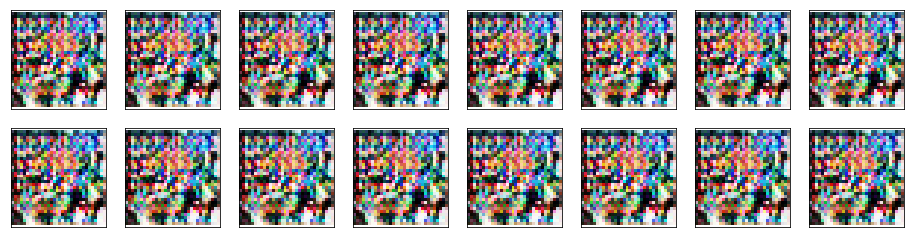

In [10]:
run_all(batch_size = 64, 
        img_size = 32, 
        d_conv_dim = 32 ,
        g_conv_dim = 32,
        z_size = 100,
        lr = 0.001, b1=0.5, b2=0.999,
        n_epochs = 20)


Training on GPU!
Number of images:  89931
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=1024, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=1024, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), 

Epoch [    3/   20] | d_loss: 0.4539 | g_loss: 0.3759
Epoch [    3/   20] | d_loss: 0.4652 | g_loss: 0.3775
Epoch [    3/   20] | d_loss: 0.4349 | g_loss: 0.3693
Epoch [    3/   20] | d_loss: 0.4382 | g_loss: 0.3578
Epoch [    3/   20] | d_loss: 0.4512 | g_loss: 0.3589
Epoch [    3/   20] | d_loss: 0.4528 | g_loss: 0.3295
Epoch [    3/   20] | d_loss: 0.4315 | g_loss: 0.3617
Epoch [    3/   20] | d_loss: 0.4512 | g_loss: 0.3431
Epoch [    3/   20] | d_loss: 0.4478 | g_loss: 0.3482
Epoch [    3/   20] | d_loss: 0.4308 | g_loss: 0.3459
Epoch [    3/   20] | d_loss: 0.4373 | g_loss: 0.3510
Epoch [    3/   20] | d_loss: 0.4339 | g_loss: 0.3467
Epoch [    3/   20] | d_loss: 0.4376 | g_loss: 0.3714
Epoch [    3/   20] | d_loss: 0.4418 | g_loss: 0.3635
Epoch [    3/   20] | d_loss: 0.4411 | g_loss: 0.3698
Epoch [    3/   20] | d_loss: 0.4428 | g_loss: 0.3538
Epoch [    3/   20] | d_loss: 0.4337 | g_loss: 0.3383
Epoch [    3/   20] | d_loss: 0.4488 | g_loss: 0.3414
Epoch [    3/   20] | d_loss

Epoch [    5/   20] | d_loss: 0.4097 | g_loss: 0.3888
Epoch [    5/   20] | d_loss: 0.4126 | g_loss: 0.3755
Epoch [    5/   20] | d_loss: 0.4128 | g_loss: 0.3714
Epoch [    5/   20] | d_loss: 0.4093 | g_loss: 0.3846
Epoch [    5/   20] | d_loss: 0.4180 | g_loss: 0.3678
Epoch [    5/   20] | d_loss: 0.4124 | g_loss: 0.3777
Epoch [    5/   20] | d_loss: 0.4121 | g_loss: 0.3789
Epoch [    5/   20] | d_loss: 0.4175 | g_loss: 0.3597
Epoch [    5/   20] | d_loss: 0.4132 | g_loss: 0.3624
Epoch [    5/   20] | d_loss: 0.4107 | g_loss: 0.3648
Epoch [    5/   20] | d_loss: 0.4090 | g_loss: 0.3648
Epoch [    5/   20] | d_loss: 0.4144 | g_loss: 0.3701
Epoch [    6/   20] | d_loss: 0.4125 | g_loss: 0.3635
Epoch [    6/   20] | d_loss: 0.4108 | g_loss: 0.3603
Epoch [    6/   20] | d_loss: 0.4113 | g_loss: 0.3618
Epoch [    6/   20] | d_loss: 0.4116 | g_loss: 0.3656
Epoch [    6/   20] | d_loss: 0.4070 | g_loss: 0.3663
Epoch [    6/   20] | d_loss: 0.4080 | g_loss: 0.3661
Epoch [    6/   20] | d_loss

Epoch [    8/   20] | d_loss: 0.3960 | g_loss: 0.3757
Epoch [    8/   20] | d_loss: 0.3996 | g_loss: 0.3811
Epoch [    8/   20] | d_loss: 0.3933 | g_loss: 0.3724
Epoch [    8/   20] | d_loss: 0.3934 | g_loss: 0.3696
Epoch [    8/   20] | d_loss: 0.3950 | g_loss: 0.3764
Epoch [    8/   20] | d_loss: 0.3944 | g_loss: 0.3819
Epoch [    8/   20] | d_loss: 0.3936 | g_loss: 0.3811
Epoch [    8/   20] | d_loss: 0.4032 | g_loss: 0.3817
Epoch [    8/   20] | d_loss: 0.4013 | g_loss: 0.3783
Epoch [    8/   20] | d_loss: 0.3954 | g_loss: 0.3760
Epoch [    8/   20] | d_loss: 0.3939 | g_loss: 0.3762
Epoch [    8/   20] | d_loss: 0.3930 | g_loss: 0.3791
Epoch [    8/   20] | d_loss: 0.3934 | g_loss: 0.3747
Epoch [    8/   20] | d_loss: 0.3950 | g_loss: 0.3804
Epoch [    8/   20] | d_loss: 0.3930 | g_loss: 0.3805
Epoch [    8/   20] | d_loss: 0.3947 | g_loss: 0.3811
Epoch [    8/   20] | d_loss: 0.3977 | g_loss: 0.3792
Epoch [    8/   20] | d_loss: 0.3973 | g_loss: 0.3770
Epoch [    8/   20] | d_loss

Epoch [   11/   20] | d_loss: 0.3936 | g_loss: 0.3934
Epoch [   11/   20] | d_loss: 0.4029 | g_loss: 0.3893
Epoch [   11/   20] | d_loss: 0.3921 | g_loss: 0.3865
Epoch [   11/   20] | d_loss: 0.3952 | g_loss: 0.3941
Epoch [   11/   20] | d_loss: 0.3929 | g_loss: 0.3900
Epoch [   11/   20] | d_loss: 0.3903 | g_loss: 0.3820
Epoch [   11/   20] | d_loss: 0.3945 | g_loss: 0.3837
Epoch [   11/   20] | d_loss: 0.3949 | g_loss: 0.3827
Epoch [   11/   20] | d_loss: 0.3931 | g_loss: 0.3840
Epoch [   11/   20] | d_loss: 0.3951 | g_loss: 0.3795
Epoch [   11/   20] | d_loss: 0.3927 | g_loss: 0.3814
Epoch [   11/   20] | d_loss: 0.3918 | g_loss: 0.3827
Epoch [   11/   20] | d_loss: 0.3942 | g_loss: 0.3778
Epoch [   11/   20] | d_loss: 0.3940 | g_loss: 0.3809
Epoch [   11/   20] | d_loss: 0.3910 | g_loss: 0.3888
Epoch [   11/   20] | d_loss: 0.3901 | g_loss: 0.3931
Epoch [   11/   20] | d_loss: 0.3965 | g_loss: 0.3969
Epoch [   11/   20] | d_loss: 0.3902 | g_loss: 0.3920
Epoch [   11/   20] | d_loss

Epoch [   13/   20] | d_loss: 0.4224 | g_loss: 0.4160
Epoch [   13/   20] | d_loss: 0.4175 | g_loss: 0.4127
Epoch [   13/   20] | d_loss: 0.3924 | g_loss: 0.4083
Epoch [   13/   20] | d_loss: 0.4067 | g_loss: 0.4019
Epoch [   13/   20] | d_loss: 0.4038 | g_loss: 0.3563
Epoch [   13/   20] | d_loss: 0.3997 | g_loss: 0.3698
Epoch [   13/   20] | d_loss: 0.4027 | g_loss: 0.3750
Epoch [   13/   20] | d_loss: 0.3966 | g_loss: 0.3795
Epoch [   13/   20] | d_loss: 0.3917 | g_loss: 0.3812
Epoch [   13/   20] | d_loss: 0.3986 | g_loss: 0.3862
Epoch [   13/   20] | d_loss: 0.3976 | g_loss: 0.3859
Epoch [   13/   20] | d_loss: 0.3944 | g_loss: 0.3873
Epoch [   14/   20] | d_loss: 0.3990 | g_loss: 0.3866
Epoch [   14/   20] | d_loss: 0.3948 | g_loss: 0.3821
Epoch [   14/   20] | d_loss: 0.3968 | g_loss: 0.3853
Epoch [   14/   20] | d_loss: 0.3945 | g_loss: 0.3863
Epoch [   14/   20] | d_loss: 0.3912 | g_loss: 0.3869
Epoch [   14/   20] | d_loss: 0.4013 | g_loss: 0.3924
Epoch [   14/   20] | d_loss

Epoch [   16/   20] | d_loss: 0.3973 | g_loss: 0.3841
Epoch [   16/   20] | d_loss: 0.3906 | g_loss: 0.3872
Epoch [   16/   20] | d_loss: 0.3905 | g_loss: 0.3785
Epoch [   16/   20] | d_loss: 0.3936 | g_loss: 0.3730
Epoch [   16/   20] | d_loss: 0.3918 | g_loss: 0.3760
Epoch [   16/   20] | d_loss: 0.3931 | g_loss: 0.3791
Epoch [   16/   20] | d_loss: 0.3955 | g_loss: 0.3846
Epoch [   16/   20] | d_loss: 0.3976 | g_loss: 0.3843
Epoch [   16/   20] | d_loss: 0.3941 | g_loss: 0.3870
Epoch [   16/   20] | d_loss: 0.3945 | g_loss: 0.3930
Epoch [   16/   20] | d_loss: 0.4008 | g_loss: 0.3855
Epoch [   16/   20] | d_loss: 0.3900 | g_loss: 0.3926
Epoch [   16/   20] | d_loss: 0.3908 | g_loss: 0.3984
Epoch [   16/   20] | d_loss: 0.4039 | g_loss: 0.3888
Epoch [   16/   20] | d_loss: 0.3930 | g_loss: 0.3956
Epoch [   16/   20] | d_loss: 0.3958 | g_loss: 0.3962
Epoch [   16/   20] | d_loss: 0.3915 | g_loss: 0.3843
Epoch [   16/   20] | d_loss: 0.3913 | g_loss: 0.3825
Epoch [   16/   20] | d_loss

Epoch [   19/   20] | d_loss: 0.4172 | g_loss: 0.3970
Epoch [   19/   20] | d_loss: 0.4261 | g_loss: 0.3864
Epoch [   19/   20] | d_loss: 0.3941 | g_loss: 0.4015
Epoch [   19/   20] | d_loss: 0.3982 | g_loss: 0.4006
Epoch [   19/   20] | d_loss: 0.3914 | g_loss: 0.3926
Epoch [   19/   20] | d_loss: 0.3927 | g_loss: 0.3952
Epoch [   19/   20] | d_loss: 0.3910 | g_loss: 0.3940
Epoch [   19/   20] | d_loss: 0.3903 | g_loss: 0.4006
Epoch [   19/   20] | d_loss: 0.3913 | g_loss: 0.3994
Epoch [   19/   20] | d_loss: 0.3952 | g_loss: 0.3977
Epoch [   19/   20] | d_loss: 0.3967 | g_loss: 0.3868
Epoch [   19/   20] | d_loss: 0.3895 | g_loss: 0.3927
Epoch [   19/   20] | d_loss: 0.3920 | g_loss: 0.3894
Epoch [   19/   20] | d_loss: 0.3935 | g_loss: 0.3887
Epoch [   19/   20] | d_loss: 0.3926 | g_loss: 0.3856
Epoch [   19/   20] | d_loss: 0.3931 | g_loss: 0.3840
Epoch [   19/   20] | d_loss: 0.3925 | g_loss: 0.3833
Epoch [   19/   20] | d_loss: 0.3933 | g_loss: 0.3907
Epoch [   19/   20] | d_loss

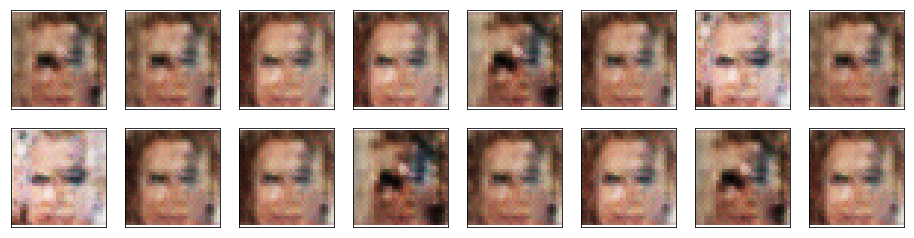

In [11]:
run_all(batch_size = 32, 
        img_size = 32, 
        d_conv_dim = 32 ,
        g_conv_dim = 32,
        z_size = 100,
        lr = 0.001, b1=0.5, b2=0.999,
        n_epochs = 20)

In [12]:
#

Training on GPU!
Number of images:  89931
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=1024, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=1024, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), 

Epoch [    3/   30] | d_loss: 0.4075 | g_loss: 0.2507
Epoch [    3/   30] | d_loss: 0.4075 | g_loss: 0.2508
Epoch [    3/   30] | d_loss: 0.4075 | g_loss: 0.2507
Epoch [    3/   30] | d_loss: 0.4075 | g_loss: 0.2508
Epoch [    3/   30] | d_loss: 0.4075 | g_loss: 0.2507
Epoch [    3/   30] | d_loss: 0.4075 | g_loss: 0.2508
Epoch [    3/   30] | d_loss: 0.4075 | g_loss: 0.2506
Epoch [    3/   30] | d_loss: 0.4075 | g_loss: 0.2506
Epoch [    3/   30] | d_loss: 0.4075 | g_loss: 0.2508
Epoch [    3/   30] | d_loss: 0.4075 | g_loss: 0.2507
Epoch [    3/   30] | d_loss: 0.4075 | g_loss: 0.2506
Epoch [    3/   30] | d_loss: 0.4075 | g_loss: 0.2508
Epoch [    3/   30] | d_loss: 0.4075 | g_loss: 0.2509
Epoch [    3/   30] | d_loss: 0.4075 | g_loss: 0.2506
Epoch [    3/   30] | d_loss: 0.4075 | g_loss: 0.2507
Epoch [    3/   30] | d_loss: 0.4075 | g_loss: 0.2508
Epoch [    3/   30] | d_loss: 0.4075 | g_loss: 0.2508
Epoch [    3/   30] | d_loss: 0.4075 | g_loss: 0.2508
Epoch [    3/   30] | d_loss

Epoch [    5/   30] | d_loss: 0.4039 | g_loss: 0.2486
Epoch [    5/   30] | d_loss: 0.4027 | g_loss: 0.2525
Epoch [    5/   30] | d_loss: 0.4028 | g_loss: 0.2448
Epoch [    5/   30] | d_loss: 0.4047 | g_loss: 0.2493
Epoch [    5/   30] | d_loss: 0.4020 | g_loss: 0.2513
Epoch [    5/   30] | d_loss: 0.4029 | g_loss: 0.2439
Epoch [    5/   30] | d_loss: 0.4055 | g_loss: 0.2452
Epoch [    5/   30] | d_loss: 0.4021 | g_loss: 0.2457
Epoch [    5/   30] | d_loss: 0.4018 | g_loss: 0.2442
Epoch [    5/   30] | d_loss: 0.4022 | g_loss: 0.2493
Epoch [    5/   30] | d_loss: 0.4044 | g_loss: 0.2463
Epoch [    5/   30] | d_loss: 0.4019 | g_loss: 0.2502
Epoch [    6/   30] | d_loss: 0.4020 | g_loss: 0.2513
Epoch [    6/   30] | d_loss: 0.4014 | g_loss: 0.2439
Epoch [    6/   30] | d_loss: 0.4018 | g_loss: 0.2443
Epoch [    6/   30] | d_loss: 0.4032 | g_loss: 0.2440
Epoch [    6/   30] | d_loss: 0.4019 | g_loss: 0.2485
Epoch [    6/   30] | d_loss: 0.4021 | g_loss: 0.2509
Epoch [    6/   30] | d_loss

Epoch [    8/   30] | d_loss: 0.4013 | g_loss: 0.2493
Epoch [    8/   30] | d_loss: 0.4028 | g_loss: 0.2448
Epoch [    8/   30] | d_loss: 0.4024 | g_loss: 0.2454
Epoch [    8/   30] | d_loss: 0.4021 | g_loss: 0.2505
Epoch [    8/   30] | d_loss: 0.4024 | g_loss: 0.2491
Epoch [    8/   30] | d_loss: 0.4028 | g_loss: 0.2482
Epoch [    8/   30] | d_loss: 0.4015 | g_loss: 0.2464
Epoch [    8/   30] | d_loss: 0.4016 | g_loss: 0.2455
Epoch [    8/   30] | d_loss: 0.4023 | g_loss: 0.2461
Epoch [    8/   30] | d_loss: 0.4019 | g_loss: 0.2474
Epoch [    8/   30] | d_loss: 0.4016 | g_loss: 0.2451
Epoch [    8/   30] | d_loss: 0.4016 | g_loss: 0.2497
Epoch [    8/   30] | d_loss: 0.4015 | g_loss: 0.2494
Epoch [    8/   30] | d_loss: 0.4017 | g_loss: 0.2478
Epoch [    8/   30] | d_loss: 0.4033 | g_loss: 0.2467
Epoch [    8/   30] | d_loss: 0.4021 | g_loss: 0.2458
Epoch [    8/   30] | d_loss: 0.4024 | g_loss: 0.2447
Epoch [    8/   30] | d_loss: 0.4020 | g_loss: 0.2464
Epoch [    8/   30] | d_loss

Epoch [   11/   30] | d_loss: 0.4019 | g_loss: 0.2443
Epoch [   11/   30] | d_loss: 0.4024 | g_loss: 0.2480
Epoch [   11/   30] | d_loss: 0.4020 | g_loss: 0.2492
Epoch [   11/   30] | d_loss: 0.4011 | g_loss: 0.2489
Epoch [   11/   30] | d_loss: 0.4020 | g_loss: 0.2482
Epoch [   11/   30] | d_loss: 0.4023 | g_loss: 0.2519
Epoch [   11/   30] | d_loss: 0.4017 | g_loss: 0.2479
Epoch [   11/   30] | d_loss: 0.4017 | g_loss: 0.2446
Epoch [   11/   30] | d_loss: 0.4014 | g_loss: 0.2462
Epoch [   11/   30] | d_loss: 0.4022 | g_loss: 0.2492
Epoch [   11/   30] | d_loss: 0.4022 | g_loss: 0.2409
Epoch [   11/   30] | d_loss: 0.4016 | g_loss: 0.2493
Epoch [   11/   30] | d_loss: 0.4016 | g_loss: 0.2485
Epoch [   11/   30] | d_loss: 0.4020 | g_loss: 0.2501
Epoch [   11/   30] | d_loss: 0.4014 | g_loss: 0.2493
Epoch [   11/   30] | d_loss: 0.4021 | g_loss: 0.2481
Epoch [   11/   30] | d_loss: 0.4014 | g_loss: 0.2484
Epoch [   11/   30] | d_loss: 0.4014 | g_loss: 0.2508
Epoch [   11/   30] | d_loss

Epoch [   13/   30] | d_loss: 0.4016 | g_loss: 0.2482
Epoch [   13/   30] | d_loss: 0.4021 | g_loss: 0.2446
Epoch [   13/   30] | d_loss: 0.4020 | g_loss: 0.2465
Epoch [   13/   30] | d_loss: 0.4014 | g_loss: 0.2474
Epoch [   13/   30] | d_loss: 0.4014 | g_loss: 0.2508
Epoch [   13/   30] | d_loss: 0.4017 | g_loss: 0.2483
Epoch [   13/   30] | d_loss: 0.4012 | g_loss: 0.2466
Epoch [   13/   30] | d_loss: 0.4014 | g_loss: 0.2477
Epoch [   13/   30] | d_loss: 0.4020 | g_loss: 0.2479
Epoch [   13/   30] | d_loss: 0.4023 | g_loss: 0.2483
Epoch [   13/   30] | d_loss: 0.4025 | g_loss: 0.2478
Epoch [   13/   30] | d_loss: 0.4018 | g_loss: 0.2477
Epoch [   14/   30] | d_loss: 0.4014 | g_loss: 0.2475
Epoch [   14/   30] | d_loss: 0.4018 | g_loss: 0.2495
Epoch [   14/   30] | d_loss: 0.4025 | g_loss: 0.2465
Epoch [   14/   30] | d_loss: 0.4011 | g_loss: 0.2489
Epoch [   14/   30] | d_loss: 0.4017 | g_loss: 0.2514
Epoch [   14/   30] | d_loss: 0.4022 | g_loss: 0.2510
Epoch [   14/   30] | d_loss

Epoch [   16/   30] | d_loss: 0.4033 | g_loss: 0.2448
Epoch [   16/   30] | d_loss: 0.4023 | g_loss: 0.2500
Epoch [   16/   30] | d_loss: 0.4030 | g_loss: 0.2417
Epoch [   16/   30] | d_loss: 0.4020 | g_loss: 0.2459
Epoch [   16/   30] | d_loss: 0.4017 | g_loss: 0.2472
Epoch [   16/   30] | d_loss: 0.4019 | g_loss: 0.2472
Epoch [   16/   30] | d_loss: 0.4021 | g_loss: 0.2468
Epoch [   16/   30] | d_loss: 0.4029 | g_loss: 0.2486
Epoch [   16/   30] | d_loss: 0.4014 | g_loss: 0.2476
Epoch [   16/   30] | d_loss: 0.4031 | g_loss: 0.2528
Epoch [   16/   30] | d_loss: 0.4015 | g_loss: 0.2470
Epoch [   16/   30] | d_loss: 0.4018 | g_loss: 0.2492
Epoch [   16/   30] | d_loss: 0.4016 | g_loss: 0.2500
Epoch [   16/   30] | d_loss: 0.4026 | g_loss: 0.2502
Epoch [   16/   30] | d_loss: 0.4016 | g_loss: 0.2484
Epoch [   16/   30] | d_loss: 0.4019 | g_loss: 0.2471
Epoch [   16/   30] | d_loss: 0.4020 | g_loss: 0.2505
Epoch [   16/   30] | d_loss: 0.4023 | g_loss: 0.2509
Epoch [   16/   30] | d_loss

Epoch [   19/   30] | d_loss: 0.4015 | g_loss: 0.2481
Epoch [   19/   30] | d_loss: 0.4019 | g_loss: 0.2465
Epoch [   19/   30] | d_loss: 0.4021 | g_loss: 0.2463
Epoch [   19/   30] | d_loss: 0.4019 | g_loss: 0.2480
Epoch [   19/   30] | d_loss: 0.4019 | g_loss: 0.2469
Epoch [   19/   30] | d_loss: 0.4023 | g_loss: 0.2471
Epoch [   19/   30] | d_loss: 0.4028 | g_loss: 0.2454
Epoch [   19/   30] | d_loss: 0.4024 | g_loss: 0.2445
Epoch [   19/   30] | d_loss: 0.4017 | g_loss: 0.2475
Epoch [   19/   30] | d_loss: 0.4017 | g_loss: 0.2518
Epoch [   19/   30] | d_loss: 0.4019 | g_loss: 0.2468
Epoch [   19/   30] | d_loss: 0.4017 | g_loss: 0.2477
Epoch [   19/   30] | d_loss: 0.4020 | g_loss: 0.2498
Epoch [   19/   30] | d_loss: 0.4020 | g_loss: 0.2496
Epoch [   19/   30] | d_loss: 0.4026 | g_loss: 0.2477
Epoch [   19/   30] | d_loss: 0.4020 | g_loss: 0.2501
Epoch [   19/   30] | d_loss: 0.4019 | g_loss: 0.2457
Epoch [   19/   30] | d_loss: 0.4024 | g_loss: 0.2494
Epoch [   19/   30] | d_loss

Epoch [   21/   30] | d_loss: 0.4019 | g_loss: 0.2499
Epoch [   21/   30] | d_loss: 0.4020 | g_loss: 0.2445
Epoch [   21/   30] | d_loss: 0.4025 | g_loss: 0.2467
Epoch [   21/   30] | d_loss: 0.4023 | g_loss: 0.2497
Epoch [   21/   30] | d_loss: 0.4022 | g_loss: 0.2503
Epoch [   21/   30] | d_loss: 0.4022 | g_loss: 0.2490
Epoch [   21/   30] | d_loss: 0.4018 | g_loss: 0.2451
Epoch [   21/   30] | d_loss: 0.4016 | g_loss: 0.2491
Epoch [   21/   30] | d_loss: 0.4023 | g_loss: 0.2497
Epoch [   21/   30] | d_loss: 0.4020 | g_loss: 0.2478
Epoch [   21/   30] | d_loss: 0.4018 | g_loss: 0.2496
Epoch [   21/   30] | d_loss: 0.4030 | g_loss: 0.2471
Epoch [   22/   30] | d_loss: 0.4024 | g_loss: 0.2516
Epoch [   22/   30] | d_loss: 0.4020 | g_loss: 0.2507
Epoch [   22/   30] | d_loss: 0.4039 | g_loss: 0.2477
Epoch [   22/   30] | d_loss: 0.4019 | g_loss: 0.2476
Epoch [   22/   30] | d_loss: 0.4035 | g_loss: 0.2473
Epoch [   22/   30] | d_loss: 0.4023 | g_loss: 0.2470
Epoch [   22/   30] | d_loss

Epoch [   24/   30] | d_loss: 0.4048 | g_loss: 0.2471
Epoch [   24/   30] | d_loss: 0.4027 | g_loss: 0.2506
Epoch [   24/   30] | d_loss: 0.4051 | g_loss: 0.2519
Epoch [   24/   30] | d_loss: 0.4028 | g_loss: 0.2510
Epoch [   24/   30] | d_loss: 0.4030 | g_loss: 0.2480
Epoch [   24/   30] | d_loss: 0.4031 | g_loss: 0.2490
Epoch [   24/   30] | d_loss: 0.4026 | g_loss: 0.2497
Epoch [   24/   30] | d_loss: 0.4021 | g_loss: 0.2475
Epoch [   24/   30] | d_loss: 0.4019 | g_loss: 0.2508
Epoch [   24/   30] | d_loss: 0.4022 | g_loss: 0.2457
Epoch [   24/   30] | d_loss: 0.4050 | g_loss: 0.2454
Epoch [   24/   30] | d_loss: 0.4022 | g_loss: 0.2466
Epoch [   24/   30] | d_loss: 0.4020 | g_loss: 0.2470
Epoch [   24/   30] | d_loss: 0.4029 | g_loss: 0.2461
Epoch [   24/   30] | d_loss: 0.4020 | g_loss: 0.2465
Epoch [   24/   30] | d_loss: 0.4019 | g_loss: 0.2480
Epoch [   24/   30] | d_loss: 0.4024 | g_loss: 0.2457
Epoch [   24/   30] | d_loss: 0.4015 | g_loss: 0.2488
Epoch [   24/   30] | d_loss

Epoch [   27/   30] | d_loss: 0.4035 | g_loss: 0.2478
Epoch [   27/   30] | d_loss: 0.4025 | g_loss: 0.2497
Epoch [   27/   30] | d_loss: 0.4018 | g_loss: 0.2483
Epoch [   27/   30] | d_loss: 0.4023 | g_loss: 0.2496
Epoch [   27/   30] | d_loss: 0.4016 | g_loss: 0.2507
Epoch [   27/   30] | d_loss: 0.4019 | g_loss: 0.2467
Epoch [   27/   30] | d_loss: 0.4017 | g_loss: 0.2494
Epoch [   27/   30] | d_loss: 0.4027 | g_loss: 0.2455
Epoch [   27/   30] | d_loss: 0.4016 | g_loss: 0.2461
Epoch [   27/   30] | d_loss: 0.4016 | g_loss: 0.2457
Epoch [   27/   30] | d_loss: 0.4020 | g_loss: 0.2519
Epoch [   27/   30] | d_loss: 0.4020 | g_loss: 0.2532
Epoch [   27/   30] | d_loss: 0.4016 | g_loss: 0.2467
Epoch [   27/   30] | d_loss: 0.4025 | g_loss: 0.2459
Epoch [   27/   30] | d_loss: 0.4024 | g_loss: 0.2478
Epoch [   27/   30] | d_loss: 0.4022 | g_loss: 0.2487
Epoch [   27/   30] | d_loss: 0.4031 | g_loss: 0.2446
Epoch [   27/   30] | d_loss: 0.4018 | g_loss: 0.2486
Epoch [   27/   30] | d_loss

Epoch [   29/   30] | d_loss: 0.4029 | g_loss: 0.2487
Epoch [   29/   30] | d_loss: 0.4020 | g_loss: 0.2489
Epoch [   29/   30] | d_loss: 0.4023 | g_loss: 0.2460
Epoch [   29/   30] | d_loss: 0.4032 | g_loss: 0.2464
Epoch [   29/   30] | d_loss: 0.4023 | g_loss: 0.2440
Epoch [   29/   30] | d_loss: 0.4018 | g_loss: 0.2531
Epoch [   29/   30] | d_loss: 0.4021 | g_loss: 0.2497
Epoch [   29/   30] | d_loss: 0.4025 | g_loss: 0.2506
Epoch [   29/   30] | d_loss: 0.4018 | g_loss: 0.2502
Epoch [   29/   30] | d_loss: 0.4020 | g_loss: 0.2497
Epoch [   29/   30] | d_loss: 0.4025 | g_loss: 0.2479
Epoch [   29/   30] | d_loss: 0.4024 | g_loss: 0.2478
Epoch [   30/   30] | d_loss: 0.4025 | g_loss: 0.2498
Epoch [   30/   30] | d_loss: 0.4026 | g_loss: 0.2444
Epoch [   30/   30] | d_loss: 0.4024 | g_loss: 0.2500
Epoch [   30/   30] | d_loss: 0.4022 | g_loss: 0.2521
Epoch [   30/   30] | d_loss: 0.4016 | g_loss: 0.2473
Epoch [   30/   30] | d_loss: 0.4016 | g_loss: 0.2479
Epoch [   30/   30] | d_loss

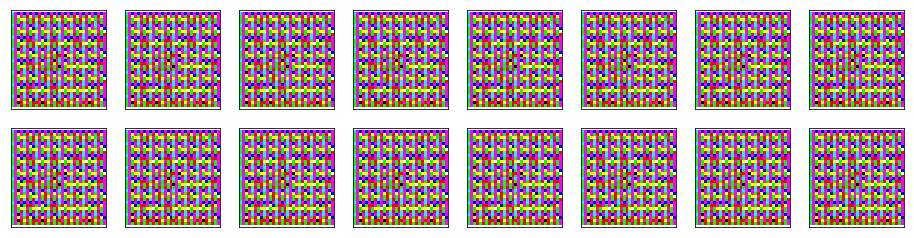

In [13]:
run_all(batch_size = 32, 
        img_size = 32, 
        d_conv_dim = 32 ,
        g_conv_dim = 32,
        z_size = 100,
        lr = 0.01, b1=0.5, b2=0.999,
        n_epochs = 30)

In [14]:
#

Training on GPU!
Number of images:  89931
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=1024, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=1024, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), 

Epoch [    3/   30] | d_loss: 0.4586 | g_loss: 0.3832
Epoch [    3/   30] | d_loss: 0.4451 | g_loss: 0.3599
Epoch [    3/   30] | d_loss: 0.4456 | g_loss: 0.3539
Epoch [    3/   30] | d_loss: 0.4450 | g_loss: 0.3632
Epoch [    3/   30] | d_loss: 0.4492 | g_loss: 0.3632
Epoch [    3/   30] | d_loss: 0.4463 | g_loss: 0.3685
Epoch [    3/   30] | d_loss: 0.4517 | g_loss: 0.3553
Epoch [    3/   30] | d_loss: 0.4720 | g_loss: 0.3780
Epoch [    3/   30] | d_loss: 0.4524 | g_loss: 0.3408
Epoch [    3/   30] | d_loss: 0.4525 | g_loss: 0.3792
Epoch [    3/   30] | d_loss: 0.4589 | g_loss: 0.3500
Epoch [    3/   30] | d_loss: 0.4542 | g_loss: 0.3498
Epoch [    3/   30] | d_loss: 0.4442 | g_loss: 0.3169
Epoch [    3/   30] | d_loss: 0.4532 | g_loss: 0.3707
Epoch [    3/   30] | d_loss: 0.4634 | g_loss: 0.3596
Epoch [    3/   30] | d_loss: 0.4803 | g_loss: 0.3659
Epoch [    3/   30] | d_loss: 0.4573 | g_loss: 0.3453
Epoch [    3/   30] | d_loss: 0.4529 | g_loss: 0.3675
Epoch [    3/   30] | d_loss

Epoch [    5/   30] | d_loss: 0.4304 | g_loss: 0.3902
Epoch [    5/   30] | d_loss: 0.4409 | g_loss: 0.3196
Epoch [    5/   30] | d_loss: 0.4335 | g_loss: 0.3783
Epoch [    5/   30] | d_loss: 0.4280 | g_loss: 0.3772
Epoch [    5/   30] | d_loss: 0.4373 | g_loss: 0.3920
Epoch [    5/   30] | d_loss: 0.4326 | g_loss: 0.3996
Epoch [    5/   30] | d_loss: 0.4288 | g_loss: 0.4056
Epoch [    5/   30] | d_loss: 0.4406 | g_loss: 0.4168
Epoch [    5/   30] | d_loss: 0.4403 | g_loss: 0.3759
Epoch [    5/   30] | d_loss: 0.4263 | g_loss: 0.3497
Epoch [    5/   30] | d_loss: 0.4568 | g_loss: 0.4052
Epoch [    5/   30] | d_loss: 0.4227 | g_loss: 0.4034
Epoch [    6/   30] | d_loss: 0.4333 | g_loss: 0.4317
Epoch [    6/   30] | d_loss: 0.4394 | g_loss: 0.4198
Epoch [    6/   30] | d_loss: 0.4445 | g_loss: 0.4018
Epoch [    6/   30] | d_loss: 0.4360 | g_loss: 0.3373
Epoch [    6/   30] | d_loss: 0.4367 | g_loss: 0.3789
Epoch [    6/   30] | d_loss: 0.4519 | g_loss: 0.3387
Epoch [    6/   30] | d_loss

Epoch [    8/   30] | d_loss: 0.4034 | g_loss: 0.3820
Epoch [    8/   30] | d_loss: 0.4032 | g_loss: 0.3799
Epoch [    8/   30] | d_loss: 0.4028 | g_loss: 0.3781
Epoch [    8/   30] | d_loss: 0.4026 | g_loss: 0.3802
Epoch [    8/   30] | d_loss: 0.3996 | g_loss: 0.3830
Epoch [    8/   30] | d_loss: 0.4031 | g_loss: 0.3818
Epoch [    8/   30] | d_loss: 0.4062 | g_loss: 0.3820
Epoch [    8/   30] | d_loss: 0.4028 | g_loss: 0.3832
Epoch [    8/   30] | d_loss: 0.4033 | g_loss: 0.3799
Epoch [    8/   30] | d_loss: 0.4012 | g_loss: 0.3792
Epoch [    8/   30] | d_loss: 0.4040 | g_loss: 0.3851
Epoch [    8/   30] | d_loss: 0.4022 | g_loss: 0.3843
Epoch [    8/   30] | d_loss: 0.4002 | g_loss: 0.3780
Epoch [    8/   30] | d_loss: 0.4002 | g_loss: 0.3802
Epoch [    8/   30] | d_loss: 0.4019 | g_loss: 0.3831
Epoch [    8/   30] | d_loss: 0.4024 | g_loss: 0.3837
Epoch [    8/   30] | d_loss: 0.3986 | g_loss: 0.3809
Epoch [    8/   30] | d_loss: 0.4035 | g_loss: 0.3791
Epoch [    8/   30] | d_loss

Epoch [   11/   30] | d_loss: 0.3906 | g_loss: 0.3975
Epoch [   11/   30] | d_loss: 0.3949 | g_loss: 0.4001
Epoch [   11/   30] | d_loss: 0.3956 | g_loss: 0.3973
Epoch [   11/   30] | d_loss: 0.3938 | g_loss: 0.3879
Epoch [   11/   30] | d_loss: 0.3941 | g_loss: 0.3898
Epoch [   11/   30] | d_loss: 0.3918 | g_loss: 0.3955
Epoch [   11/   30] | d_loss: 0.3941 | g_loss: 0.3876
Epoch [   11/   30] | d_loss: 0.3975 | g_loss: 0.3853
Epoch [   11/   30] | d_loss: 0.3910 | g_loss: 0.3854
Epoch [   11/   30] | d_loss: 0.3924 | g_loss: 0.3884
Epoch [   11/   30] | d_loss: 0.3959 | g_loss: 0.3912
Epoch [   11/   30] | d_loss: 0.3937 | g_loss: 0.3956
Epoch [   11/   30] | d_loss: 0.3902 | g_loss: 0.3975
Epoch [   11/   30] | d_loss: 0.3983 | g_loss: 0.3957
Epoch [   11/   30] | d_loss: 0.3939 | g_loss: 0.3918
Epoch [   11/   30] | d_loss: 0.3915 | g_loss: 0.3924
Epoch [   11/   30] | d_loss: 0.3913 | g_loss: 0.3936
Epoch [   11/   30] | d_loss: 0.3983 | g_loss: 0.3900
Epoch [   11/   30] | d_loss

Epoch [   13/   30] | d_loss: 0.3885 | g_loss: 0.3949
Epoch [   13/   30] | d_loss: 0.3898 | g_loss: 0.4021
Epoch [   13/   30] | d_loss: 0.3902 | g_loss: 0.3933
Epoch [   13/   30] | d_loss: 0.3939 | g_loss: 0.3945
Epoch [   13/   30] | d_loss: 0.3899 | g_loss: 0.4037
Epoch [   13/   30] | d_loss: 0.3951 | g_loss: 0.3976
Epoch [   13/   30] | d_loss: 0.3892 | g_loss: 0.3927
Epoch [   13/   30] | d_loss: 0.3897 | g_loss: 0.4032
Epoch [   13/   30] | d_loss: 0.3975 | g_loss: 0.4096
Epoch [   13/   30] | d_loss: 0.3901 | g_loss: 0.4076
Epoch [   13/   30] | d_loss: 0.3911 | g_loss: 0.3973
Epoch [   13/   30] | d_loss: 0.3952 | g_loss: 0.3982
Epoch [   14/   30] | d_loss: 0.3941 | g_loss: 0.3998
Epoch [   14/   30] | d_loss: 0.3931 | g_loss: 0.3956
Epoch [   14/   30] | d_loss: 0.3941 | g_loss: 0.3903
Epoch [   14/   30] | d_loss: 0.3932 | g_loss: 0.3930
Epoch [   14/   30] | d_loss: 0.3950 | g_loss: 0.3889
Epoch [   14/   30] | d_loss: 0.3908 | g_loss: 0.3949
Epoch [   14/   30] | d_loss

Epoch [   16/   30] | d_loss: 0.3880 | g_loss: 0.4014
Epoch [   16/   30] | d_loss: 0.3891 | g_loss: 0.4035
Epoch [   16/   30] | d_loss: 0.3983 | g_loss: 0.4046
Epoch [   16/   30] | d_loss: 0.3934 | g_loss: 0.4030
Epoch [   16/   30] | d_loss: 0.3910 | g_loss: 0.3869
Epoch [   16/   30] | d_loss: 0.3900 | g_loss: 0.3930
Epoch [   16/   30] | d_loss: 0.3927 | g_loss: 0.3998
Epoch [   16/   30] | d_loss: 0.3890 | g_loss: 0.4052
Epoch [   16/   30] | d_loss: 0.3888 | g_loss: 0.3999
Epoch [   16/   30] | d_loss: 0.3893 | g_loss: 0.4003
Epoch [   16/   30] | d_loss: 0.3896 | g_loss: 0.4068
Epoch [   16/   30] | d_loss: 0.3951 | g_loss: 0.4027
Epoch [   16/   30] | d_loss: 0.3920 | g_loss: 0.4036
Epoch [   16/   30] | d_loss: 0.3897 | g_loss: 0.3983
Epoch [   16/   30] | d_loss: 0.3892 | g_loss: 0.4002
Epoch [   16/   30] | d_loss: 0.3946 | g_loss: 0.4009
Epoch [   16/   30] | d_loss: 0.3886 | g_loss: 0.4075
Epoch [   16/   30] | d_loss: 0.3908 | g_loss: 0.4049
Epoch [   16/   30] | d_loss

Epoch [   19/   30] | d_loss: 0.4278 | g_loss: 0.4471
Epoch [   19/   30] | d_loss: 0.4294 | g_loss: 0.4381
Epoch [   19/   30] | d_loss: 0.4317 | g_loss: 0.4453
Epoch [   19/   30] | d_loss: 0.4286 | g_loss: 0.4438
Epoch [   19/   30] | d_loss: 0.4278 | g_loss: 0.4472
Epoch [   19/   30] | d_loss: 0.4720 | g_loss: 0.4464
Epoch [   19/   30] | d_loss: 0.4337 | g_loss: 0.4409
Epoch [   19/   30] | d_loss: 0.4280 | g_loss: 0.4464
Epoch [   19/   30] | d_loss: 0.4276 | g_loss: 0.4459
Epoch [   19/   30] | d_loss: 0.4276 | g_loss: 0.4467
Epoch [   19/   30] | d_loss: 0.4275 | g_loss: 0.4460
Epoch [   19/   30] | d_loss: 0.4707 | g_loss: 0.4381
Epoch [   19/   30] | d_loss: 0.4633 | g_loss: 0.4367
Epoch [   19/   30] | d_loss: 0.4542 | g_loss: 0.4260
Epoch [   19/   30] | d_loss: 0.4420 | g_loss: 0.4422
Epoch [   19/   30] | d_loss: 0.4419 | g_loss: 0.4457
Epoch [   19/   30] | d_loss: 0.4419 | g_loss: 0.4300
Epoch [   19/   30] | d_loss: 0.4411 | g_loss: 0.4017
Epoch [   19/   30] | d_loss

Epoch [   21/   30] | d_loss: 0.4217 | g_loss: 0.4038
Epoch [   21/   30] | d_loss: 0.4179 | g_loss: 0.4378
Epoch [   21/   30] | d_loss: 0.4276 | g_loss: 0.4305
Epoch [   21/   30] | d_loss: 0.4612 | g_loss: 0.4215
Epoch [   21/   30] | d_loss: 0.4347 | g_loss: 0.4137
Epoch [   21/   30] | d_loss: 0.4273 | g_loss: 0.4171
Epoch [   21/   30] | d_loss: 0.4237 | g_loss: 0.4243
Epoch [   21/   30] | d_loss: 0.4261 | g_loss: 0.4285
Epoch [   21/   30] | d_loss: 0.4227 | g_loss: 0.4338
Epoch [   21/   30] | d_loss: 0.4211 | g_loss: 0.4293
Epoch [   21/   30] | d_loss: 0.4194 | g_loss: 0.4286
Epoch [   21/   30] | d_loss: 0.4219 | g_loss: 0.4202
Epoch [   22/   30] | d_loss: 0.4197 | g_loss: 0.4312
Epoch [   22/   30] | d_loss: 0.4237 | g_loss: 0.4183
Epoch [   22/   30] | d_loss: 0.4277 | g_loss: 0.4217
Epoch [   22/   30] | d_loss: 0.4244 | g_loss: 0.4333
Epoch [   22/   30] | d_loss: 0.4165 | g_loss: 0.4285
Epoch [   22/   30] | d_loss: 0.4150 | g_loss: 0.4308
Epoch [   22/   30] | d_loss

Epoch [   24/   30] | d_loss: 0.4087 | g_loss: 0.4113
Epoch [   24/   30] | d_loss: 0.4207 | g_loss: 0.4046
Epoch [   24/   30] | d_loss: 0.4126 | g_loss: 0.4043
Epoch [   24/   30] | d_loss: 0.4251 | g_loss: 0.4012
Epoch [   24/   30] | d_loss: 0.4209 | g_loss: 0.4097
Epoch [   24/   30] | d_loss: 0.4056 | g_loss: 0.4247
Epoch [   24/   30] | d_loss: 0.4167 | g_loss: 0.3972
Epoch [   24/   30] | d_loss: 0.4118 | g_loss: 0.3822
Epoch [   24/   30] | d_loss: 0.4088 | g_loss: 0.3816
Epoch [   24/   30] | d_loss: 0.4045 | g_loss: 0.3873
Epoch [   24/   30] | d_loss: 0.4115 | g_loss: 0.3914
Epoch [   24/   30] | d_loss: 0.4083 | g_loss: 0.4122
Epoch [   24/   30] | d_loss: 0.4018 | g_loss: 0.3910
Epoch [   24/   30] | d_loss: 0.4038 | g_loss: 0.3913
Epoch [   24/   30] | d_loss: 0.4097 | g_loss: 0.4067
Epoch [   24/   30] | d_loss: 0.4040 | g_loss: 0.4054
Epoch [   24/   30] | d_loss: 0.4107 | g_loss: 0.3949
Epoch [   24/   30] | d_loss: 0.4036 | g_loss: 0.3904
Epoch [   24/   30] | d_loss

Epoch [   27/   30] | d_loss: 0.3934 | g_loss: 0.3979
Epoch [   27/   30] | d_loss: 0.3918 | g_loss: 0.3993
Epoch [   27/   30] | d_loss: 0.3930 | g_loss: 0.3954
Epoch [   27/   30] | d_loss: 0.3928 | g_loss: 0.3985
Epoch [   27/   30] | d_loss: 0.3904 | g_loss: 0.3981
Epoch [   27/   30] | d_loss: 0.4012 | g_loss: 0.4034
Epoch [   27/   30] | d_loss: 0.3966 | g_loss: 0.4071
Epoch [   27/   30] | d_loss: 0.3965 | g_loss: 0.4042
Epoch [   27/   30] | d_loss: 0.3914 | g_loss: 0.3995
Epoch [   27/   30] | d_loss: 0.3911 | g_loss: 0.4023
Epoch [   27/   30] | d_loss: 0.3910 | g_loss: 0.4014
Epoch [   27/   30] | d_loss: 0.3927 | g_loss: 0.3976
Epoch [   27/   30] | d_loss: 0.3901 | g_loss: 0.3968
Epoch [   27/   30] | d_loss: 0.3932 | g_loss: 0.4017
Epoch [   27/   30] | d_loss: 0.3896 | g_loss: 0.4035
Epoch [   27/   30] | d_loss: 0.3929 | g_loss: 0.3987
Epoch [   27/   30] | d_loss: 0.3919 | g_loss: 0.3997
Epoch [   27/   30] | d_loss: 0.3937 | g_loss: 0.3995
Epoch [   27/   30] | d_loss

Epoch [   29/   30] | d_loss: 0.3938 | g_loss: 0.3987
Epoch [   29/   30] | d_loss: 0.3926 | g_loss: 0.3958
Epoch [   29/   30] | d_loss: 0.3915 | g_loss: 0.3947
Epoch [   29/   30] | d_loss: 0.3953 | g_loss: 0.3942
Epoch [   29/   30] | d_loss: 0.3912 | g_loss: 0.3978
Epoch [   29/   30] | d_loss: 0.3908 | g_loss: 0.4022
Epoch [   29/   30] | d_loss: 0.3911 | g_loss: 0.4064
Epoch [   29/   30] | d_loss: 0.3883 | g_loss: 0.4006
Epoch [   29/   30] | d_loss: 0.3909 | g_loss: 0.4050
Epoch [   29/   30] | d_loss: 0.3899 | g_loss: 0.4014
Epoch [   29/   30] | d_loss: 0.3951 | g_loss: 0.4029
Epoch [   29/   30] | d_loss: 0.3899 | g_loss: 0.3965
Epoch [   30/   30] | d_loss: 0.3908 | g_loss: 0.3969
Epoch [   30/   30] | d_loss: 0.3934 | g_loss: 0.4033
Epoch [   30/   30] | d_loss: 0.3907 | g_loss: 0.4042
Epoch [   30/   30] | d_loss: 0.3975 | g_loss: 0.4090
Epoch [   30/   30] | d_loss: 0.3922 | g_loss: 0.4064
Epoch [   30/   30] | d_loss: 0.3903 | g_loss: 0.4047
Epoch [   30/   30] | d_loss

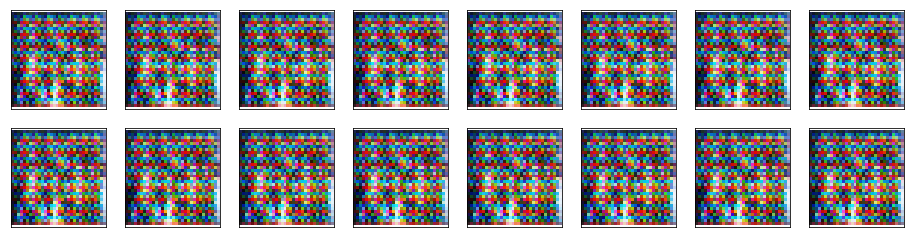

In [15]:
run_all(batch_size = 32, 
        img_size = 32, 
        d_conv_dim = 32 ,
        g_conv_dim = 32,
        z_size = 100,
        lr = 0.001, b1=0.5, b2=0.999,
        n_epochs = 30)

Training on GPU!
Number of images:  89931
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=1024, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=1024, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), 

Epoch [    2/   30] | d_loss: 0.4674 | g_loss: 0.3645
Epoch [    2/   30] | d_loss: 0.4701 | g_loss: 0.3682
Epoch [    2/   30] | d_loss: 0.4548 | g_loss: 0.3694
Epoch [    2/   30] | d_loss: 0.4569 | g_loss: 0.3688
Epoch [    2/   30] | d_loss: 0.4883 | g_loss: 0.3943
Epoch [    2/   30] | d_loss: 0.4515 | g_loss: 0.3819
Epoch [    2/   30] | d_loss: 0.4577 | g_loss: 0.3543
Epoch [    2/   30] | d_loss: 0.4693 | g_loss: 0.3830
Epoch [    2/   30] | d_loss: 0.4664 | g_loss: 0.3753
Epoch [    2/   30] | d_loss: 0.4671 | g_loss: 0.4174
Epoch [    2/   30] | d_loss: 0.4814 | g_loss: 0.3917
Epoch [    2/   30] | d_loss: 0.4797 | g_loss: 0.3977
Epoch [    2/   30] | d_loss: 0.4493 | g_loss: 0.3873
Epoch [    2/   30] | d_loss: 0.4687 | g_loss: 0.3880
Epoch [    2/   30] | d_loss: 0.4916 | g_loss: 0.3795
Epoch [    2/   30] | d_loss: 0.4717 | g_loss: 0.3885
Epoch [    2/   30] | d_loss: 0.4691 | g_loss: 0.3979
Epoch [    2/   30] | d_loss: 0.4589 | g_loss: 0.4087
Epoch [    2/   30] | d_loss

Epoch [    3/   30] | d_loss: 0.4404 | g_loss: 0.4489
Epoch [    3/   30] | d_loss: 0.4649 | g_loss: 0.4460
Epoch [    3/   30] | d_loss: 0.4389 | g_loss: 0.4431
Epoch [    3/   30] | d_loss: 0.4717 | g_loss: 0.3645
Epoch [    3/   30] | d_loss: 0.4682 | g_loss: 0.3920
Epoch [    3/   30] | d_loss: 0.4156 | g_loss: 0.4542
Epoch [    3/   30] | d_loss: 0.4183 | g_loss: 0.4393
Epoch [    3/   30] | d_loss: 0.4164 | g_loss: 0.4415
Epoch [    3/   30] | d_loss: 0.4141 | g_loss: 0.4233
Epoch [    3/   30] | d_loss: 0.4215 | g_loss: 0.4199
Epoch [    3/   30] | d_loss: 0.4147 | g_loss: 0.4195
Epoch [    3/   30] | d_loss: 0.4114 | g_loss: 0.4371
Epoch [    3/   30] | d_loss: 0.4253 | g_loss: 0.4073
Epoch [    3/   30] | d_loss: 0.4079 | g_loss: 0.4217
Epoch [    3/   30] | d_loss: 0.4189 | g_loss: 0.4244
Epoch [    3/   30] | d_loss: 0.4071 | g_loss: 0.4247
Epoch [    3/   30] | d_loss: 0.4119 | g_loss: 0.4159
Epoch [    3/   30] | d_loss: 0.4188 | g_loss: 0.4046
Epoch [    3/   30] | d_loss

Epoch [    4/   30] | d_loss: 0.4739 | g_loss: 0.3642
Epoch [    4/   30] | d_loss: 0.4545 | g_loss: 0.4197
Epoch [    4/   30] | d_loss: 0.4278 | g_loss: 0.4580
Epoch [    4/   30] | d_loss: 0.4359 | g_loss: 0.4394
Epoch [    4/   30] | d_loss: 0.4778 | g_loss: 0.4260
Epoch [    4/   30] | d_loss: 0.4388 | g_loss: 0.3733
Epoch [    4/   30] | d_loss: 0.4407 | g_loss: 0.4355
Epoch [    4/   30] | d_loss: 0.4362 | g_loss: 0.4593
Epoch [    4/   30] | d_loss: 0.4326 | g_loss: 0.4034
Epoch [    4/   30] | d_loss: 0.4361 | g_loss: 0.4673
Epoch [    4/   30] | d_loss: 0.4483 | g_loss: 0.3981
Epoch [    4/   30] | d_loss: 0.4328 | g_loss: 0.4272
Epoch [    4/   30] | d_loss: 0.4268 | g_loss: 0.4681
Epoch [    4/   30] | d_loss: 0.4411 | g_loss: 0.4280
Epoch [    4/   30] | d_loss: 0.4469 | g_loss: 0.4652
Epoch [    4/   30] | d_loss: 0.4313 | g_loss: 0.4113
Epoch [    4/   30] | d_loss: 0.4385 | g_loss: 0.4709
Epoch [    4/   30] | d_loss: 0.4408 | g_loss: 0.4172
Epoch [    4/   30] | d_loss

Epoch [    6/   30] | d_loss: 0.3911 | g_loss: 0.4333
Epoch [    6/   30] | d_loss: 0.3913 | g_loss: 0.4374
Epoch [    6/   30] | d_loss: 0.3898 | g_loss: 0.4287
Epoch [    6/   30] | d_loss: 0.3905 | g_loss: 0.4417
Epoch [    6/   30] | d_loss: 0.3911 | g_loss: 0.4454
Epoch [    6/   30] | d_loss: 0.3892 | g_loss: 0.4425
Epoch [    6/   30] | d_loss: 0.3982 | g_loss: 0.4428
Epoch [    6/   30] | d_loss: 0.3989 | g_loss: 0.4401
Epoch [    6/   30] | d_loss: 0.3884 | g_loss: 0.4350
Epoch [    6/   30] | d_loss: 0.3981 | g_loss: 0.4487
Epoch [    6/   30] | d_loss: 0.3956 | g_loss: 0.4474
Epoch [    6/   30] | d_loss: 0.3988 | g_loss: 0.4402
Epoch [    6/   30] | d_loss: 0.3893 | g_loss: 0.4353
Epoch [    6/   30] | d_loss: 0.3912 | g_loss: 0.4365
Epoch [    6/   30] | d_loss: 0.3977 | g_loss: 0.4319
Epoch [    6/   30] | d_loss: 0.3989 | g_loss: 0.4322
Epoch [    6/   30] | d_loss: 0.3917 | g_loss: 0.4388
Epoch [    6/   30] | d_loss: 0.3969 | g_loss: 0.4406
Epoch [    6/   30] | d_loss

Epoch [    7/   30] | d_loss: 0.4084 | g_loss: 0.4431
Epoch [    7/   30] | d_loss: 0.3970 | g_loss: 0.4506
Epoch [    7/   30] | d_loss: 0.3903 | g_loss: 0.4451
Epoch [    7/   30] | d_loss: 0.3940 | g_loss: 0.4447
Epoch [    7/   30] | d_loss: 0.3877 | g_loss: 0.4422
Epoch [    7/   30] | d_loss: 0.3871 | g_loss: 0.4506
Epoch [    7/   30] | d_loss: 0.4233 | g_loss: 0.4456
Epoch [    7/   30] | d_loss: 0.3873 | g_loss: 0.4411
Epoch [    7/   30] | d_loss: 0.3915 | g_loss: 0.4415
Epoch [    7/   30] | d_loss: 0.3886 | g_loss: 0.4456
Epoch [    7/   30] | d_loss: 0.3902 | g_loss: 0.4311
Epoch [    7/   30] | d_loss: 0.3985 | g_loss: 0.4296
Epoch [    7/   30] | d_loss: 0.3964 | g_loss: 0.4658
Epoch [    7/   30] | d_loss: 0.4023 | g_loss: 0.4246
Epoch [    7/   30] | d_loss: 0.3878 | g_loss: 0.4338
Epoch [    7/   30] | d_loss: 0.3992 | g_loss: 0.4461
Epoch [    7/   30] | d_loss: 0.3959 | g_loss: 0.4425
Epoch [    7/   30] | d_loss: 0.3939 | g_loss: 0.4402
Epoch [    7/   30] | d_loss

Epoch [    8/   30] | d_loss: 0.4011 | g_loss: 0.4298
Epoch [    8/   30] | d_loss: 0.3903 | g_loss: 0.4339
Epoch [    8/   30] | d_loss: 0.3971 | g_loss: 0.4351
Epoch [    8/   30] | d_loss: 0.3951 | g_loss: 0.4313
Epoch [    8/   30] | d_loss: 0.3855 | g_loss: 0.4364
Epoch [    8/   30] | d_loss: 0.3930 | g_loss: 0.4453
Epoch [    8/   30] | d_loss: 0.3859 | g_loss: 0.4576
Epoch [    8/   30] | d_loss: 0.3910 | g_loss: 0.4632
Epoch [    8/   30] | d_loss: 0.3892 | g_loss: 0.4514
Epoch [    8/   30] | d_loss: 0.3926 | g_loss: 0.4541
Epoch [    8/   30] | d_loss: 0.3870 | g_loss: 0.4518
Epoch [    8/   30] | d_loss: 0.3882 | g_loss: 0.4343
Epoch [    8/   30] | d_loss: 0.3907 | g_loss: 0.4422
Epoch [    8/   30] | d_loss: 0.4196 | g_loss: 0.4426
Epoch [    8/   30] | d_loss: 0.3940 | g_loss: 0.4517
Epoch [    8/   30] | d_loss: 0.3867 | g_loss: 0.4472
Epoch [    8/   30] | d_loss: 0.3936 | g_loss: 0.4449
Epoch [    8/   30] | d_loss: 0.4002 | g_loss: 0.4582
Epoch [    8/   30] | d_loss

Epoch [   10/   30] | d_loss: 0.3975 | g_loss: 0.4586
Epoch [   10/   30] | d_loss: 0.4086 | g_loss: 0.4368
Epoch [   10/   30] | d_loss: 0.5134 | g_loss: 0.4684
Epoch [   10/   30] | d_loss: 0.4138 | g_loss: 0.4444
Epoch [   10/   30] | d_loss: 0.4188 | g_loss: 0.4625
Epoch [   10/   30] | d_loss: 0.3908 | g_loss: 0.4719
Epoch [   10/   30] | d_loss: 0.4153 | g_loss: 0.4519
Epoch [   10/   30] | d_loss: 0.3988 | g_loss: 0.4555
Epoch [   10/   30] | d_loss: 0.4120 | g_loss: 0.4431
Epoch [   10/   30] | d_loss: 0.4048 | g_loss: 0.4523
Epoch [   10/   30] | d_loss: 0.4114 | g_loss: 0.4546
Epoch [   10/   30] | d_loss: 0.4123 | g_loss: 0.4711
Epoch [   10/   30] | d_loss: 0.3980 | g_loss: 0.4848
Epoch [   10/   30] | d_loss: 0.3991 | g_loss: 0.4790
Epoch [   10/   30] | d_loss: 0.3926 | g_loss: 0.4665
Epoch [   10/   30] | d_loss: 0.4056 | g_loss: 0.4725
Epoch [   10/   30] | d_loss: 0.3984 | g_loss: 0.4649
Epoch [   10/   30] | d_loss: 0.3927 | g_loss: 0.4656
Epoch [   10/   30] | d_loss

Epoch [   11/   30] | d_loss: 0.3878 | g_loss: 0.4594
Epoch [   11/   30] | d_loss: 0.3859 | g_loss: 0.4692
Epoch [   11/   30] | d_loss: 0.3879 | g_loss: 0.4620
Epoch [   11/   30] | d_loss: 0.4071 | g_loss: 0.4538
Epoch [   11/   30] | d_loss: 0.4096 | g_loss: 0.4561
Epoch [   11/   30] | d_loss: 0.3956 | g_loss: 0.4531
Epoch [   11/   30] | d_loss: 0.3850 | g_loss: 0.4467
Epoch [   11/   30] | d_loss: 0.3889 | g_loss: 0.4492
Epoch [   11/   30] | d_loss: 0.3878 | g_loss: 0.4482
Epoch [   11/   30] | d_loss: 0.3869 | g_loss: 0.4409
Epoch [   11/   30] | d_loss: 0.3949 | g_loss: 0.4486
Epoch [   11/   30] | d_loss: 0.3873 | g_loss: 0.4445
Epoch [   11/   30] | d_loss: 0.3971 | g_loss: 0.4443
Epoch [   11/   30] | d_loss: 0.3908 | g_loss: 0.4496
Epoch [   11/   30] | d_loss: 0.4158 | g_loss: 0.4515
Epoch [   11/   30] | d_loss: 0.3881 | g_loss: 0.4492
Epoch [   11/   30] | d_loss: 0.3946 | g_loss: 0.4517
Epoch [   11/   30] | d_loss: 0.4179 | g_loss: 0.4509
Epoch [   11/   30] | d_loss

Epoch [   12/   30] | d_loss: 0.3840 | g_loss: 0.4517
Epoch [   12/   30] | d_loss: 0.3884 | g_loss: 0.4436
Epoch [   12/   30] | d_loss: 0.4004 | g_loss: 0.4390
Epoch [   12/   30] | d_loss: 0.3928 | g_loss: 0.4369
Epoch [   12/   30] | d_loss: 0.3877 | g_loss: 0.4405
Epoch [   12/   30] | d_loss: 0.3845 | g_loss: 0.4412
Epoch [   12/   30] | d_loss: 0.4141 | g_loss: 0.4440
Epoch [   12/   30] | d_loss: 0.4110 | g_loss: 0.4456
Epoch [   12/   30] | d_loss: 0.3887 | g_loss: 0.4458
Epoch [   12/   30] | d_loss: 0.3880 | g_loss: 0.4488
Epoch [   12/   30] | d_loss: 0.3870 | g_loss: 0.4548
Epoch [   12/   30] | d_loss: 0.3900 | g_loss: 0.4582
Epoch [   12/   30] | d_loss: 0.3849 | g_loss: 0.4515
Epoch [   12/   30] | d_loss: 0.3883 | g_loss: 0.4578
Epoch [   12/   30] | d_loss: 0.3842 | g_loss: 0.4601
Epoch [   12/   30] | d_loss: 0.3869 | g_loss: 0.4583
Epoch [   12/   30] | d_loss: 0.4098 | g_loss: 0.4543
Epoch [   12/   30] | d_loss: 0.3877 | g_loss: 0.4523
Epoch [   12/   30] | d_loss

Epoch [   14/   30] | d_loss: 0.3845 | g_loss: 0.4536
Epoch [   14/   30] | d_loss: 0.3875 | g_loss: 0.4581
Epoch [   14/   30] | d_loss: 0.3876 | g_loss: 0.4566
Epoch [   14/   30] | d_loss: 0.3868 | g_loss: 0.4677
Epoch [   14/   30] | d_loss: 0.3859 | g_loss: 0.4649
Epoch [   14/   30] | d_loss: 0.3862 | g_loss: 0.4689
Epoch [   14/   30] | d_loss: 0.3847 | g_loss: 0.4666
Epoch [   14/   30] | d_loss: 0.3867 | g_loss: 0.4671
Epoch [   14/   30] | d_loss: 0.3877 | g_loss: 0.4577
Epoch [   14/   30] | d_loss: 0.3866 | g_loss: 0.4652
Epoch [   14/   30] | d_loss: 0.3870 | g_loss: 0.4592
Epoch [   14/   30] | d_loss: 0.3879 | g_loss: 0.4563
Epoch [   14/   30] | d_loss: 0.3874 | g_loss: 0.4525
Epoch [   14/   30] | d_loss: 0.3876 | g_loss: 0.4576
Epoch [   14/   30] | d_loss: 0.3876 | g_loss: 0.4541
Epoch [   14/   30] | d_loss: 0.3873 | g_loss: 0.4564
Epoch [   14/   30] | d_loss: 0.3893 | g_loss: 0.4540
Epoch [   14/   30] | d_loss: 0.3864 | g_loss: 0.4504
Epoch [   14/   30] | d_loss

Epoch [   15/   30] | d_loss: 0.3837 | g_loss: 0.4516
Epoch [   15/   30] | d_loss: 0.3886 | g_loss: 0.4537
Epoch [   15/   30] | d_loss: 0.3980 | g_loss: 0.4512
Epoch [   15/   30] | d_loss: 0.3879 | g_loss: 0.4444
Epoch [   15/   30] | d_loss: 0.3894 | g_loss: 0.4527
Epoch [   15/   30] | d_loss: 0.3848 | g_loss: 0.4550
Epoch [   15/   30] | d_loss: 0.3892 | g_loss: 0.4610
Epoch [   15/   30] | d_loss: 0.4266 | g_loss: 0.4599
Epoch [   15/   30] | d_loss: 0.4722 | g_loss: 0.3713
Epoch [   15/   30] | d_loss: 0.3950 | g_loss: 0.4751
Epoch [   15/   30] | d_loss: 0.3930 | g_loss: 0.4679
Epoch [   15/   30] | d_loss: 0.3988 | g_loss: 0.4576
Epoch [   15/   30] | d_loss: 0.3975 | g_loss: 0.4549
Epoch [   15/   30] | d_loss: 0.3849 | g_loss: 0.4525
Epoch [   15/   30] | d_loss: 0.3837 | g_loss: 0.4582
Epoch [   15/   30] | d_loss: 0.4010 | g_loss: 0.4675
Epoch [   15/   30] | d_loss: 0.3840 | g_loss: 0.4557
Epoch [   15/   30] | d_loss: 0.3938 | g_loss: 0.4650
Epoch [   15/   30] | d_loss

Epoch [   16/   30] | d_loss: 0.4057 | g_loss: 0.4411
Epoch [   16/   30] | d_loss: 0.3853 | g_loss: 0.4480
Epoch [   16/   30] | d_loss: 0.4070 | g_loss: 0.4395
Epoch [   16/   30] | d_loss: 0.3852 | g_loss: 0.4373
Epoch [   16/   30] | d_loss: 0.3915 | g_loss: 0.4335
Epoch [   16/   30] | d_loss: 0.3903 | g_loss: 0.4371
Epoch [   16/   30] | d_loss: 0.3874 | g_loss: 0.4337
Epoch [   16/   30] | d_loss: 0.3866 | g_loss: 0.4351
Epoch [   16/   30] | d_loss: 0.3845 | g_loss: 0.4362
Epoch [   16/   30] | d_loss: 0.3882 | g_loss: 0.4465
Epoch [   16/   30] | d_loss: 0.3845 | g_loss: 0.4437
Epoch [   16/   30] | d_loss: 0.3862 | g_loss: 0.4457
Epoch [   16/   30] | d_loss: 0.3850 | g_loss: 0.4472
Epoch [   16/   30] | d_loss: 0.3946 | g_loss: 0.4526
Epoch [   16/   30] | d_loss: 0.4014 | g_loss: 0.4579
Epoch [   17/   30] | d_loss: 0.3897 | g_loss: 0.4517
Epoch [   17/   30] | d_loss: 0.4277 | g_loss: 0.4552
Epoch [   17/   30] | d_loss: 0.3851 | g_loss: 0.4477
Epoch [   17/   30] | d_loss

Epoch [   18/   30] | d_loss: 0.3998 | g_loss: 0.4649
Epoch [   18/   30] | d_loss: 0.3954 | g_loss: 0.4588
Epoch [   18/   30] | d_loss: 0.3884 | g_loss: 0.4625
Epoch [   18/   30] | d_loss: 0.3978 | g_loss: 0.4657
Epoch [   18/   30] | d_loss: 0.3886 | g_loss: 0.4610
Epoch [   18/   30] | d_loss: 0.4032 | g_loss: 0.4561
Epoch [   18/   30] | d_loss: 0.3938 | g_loss: 0.4519
Epoch [   18/   30] | d_loss: 0.3851 | g_loss: 0.4448
Epoch [   18/   30] | d_loss: 0.3842 | g_loss: 0.4442
Epoch [   18/   30] | d_loss: 0.3986 | g_loss: 0.4486
Epoch [   18/   30] | d_loss: 0.3846 | g_loss: 0.4504
Epoch [   18/   30] | d_loss: 0.3936 | g_loss: 0.4499
Epoch [   18/   30] | d_loss: 0.3886 | g_loss: 0.4479
Epoch [   18/   30] | d_loss: 0.3925 | g_loss: 0.4465
Epoch [   18/   30] | d_loss: 0.3890 | g_loss: 0.4548
Epoch [   18/   30] | d_loss: 0.3943 | g_loss: 0.4520
Epoch [   18/   30] | d_loss: 0.4007 | g_loss: 0.4541
Epoch [   18/   30] | d_loss: 0.3845 | g_loss: 0.4455
Epoch [   18/   30] | d_loss

Epoch [   19/   30] | d_loss: 0.3870 | g_loss: 0.4674
Epoch [   19/   30] | d_loss: 0.3884 | g_loss: 0.4550
Epoch [   19/   30] | d_loss: 0.3849 | g_loss: 0.4433
Epoch [   19/   30] | d_loss: 0.4034 | g_loss: 0.4484
Epoch [   19/   30] | d_loss: 0.3932 | g_loss: 0.4474
Epoch [   19/   30] | d_loss: 0.3891 | g_loss: 0.4496
Epoch [   19/   30] | d_loss: 0.3914 | g_loss: 0.4458
Epoch [   19/   30] | d_loss: 0.3842 | g_loss: 0.4492
Epoch [   19/   30] | d_loss: 0.3889 | g_loss: 0.4599
Epoch [   19/   30] | d_loss: 0.3920 | g_loss: 0.4598
Epoch [   19/   30] | d_loss: 0.3940 | g_loss: 0.4462
Epoch [   19/   30] | d_loss: 0.3901 | g_loss: 0.4468
Epoch [   19/   30] | d_loss: 0.3902 | g_loss: 0.4457
Epoch [   19/   30] | d_loss: 0.3871 | g_loss: 0.4513
Epoch [   19/   30] | d_loss: 0.3899 | g_loss: 0.4497
Epoch [   19/   30] | d_loss: 0.3890 | g_loss: 0.4550
Epoch [   19/   30] | d_loss: 0.3839 | g_loss: 0.4495
Epoch [   19/   30] | d_loss: 0.3887 | g_loss: 0.4558
Epoch [   19/   30] | d_loss

Epoch [   20/   30] | d_loss: 0.3902 | g_loss: 0.4578
Epoch [   20/   30] | d_loss: 0.3846 | g_loss: 0.4402
Epoch [   20/   30] | d_loss: 0.3924 | g_loss: 0.4340
Epoch [   20/   30] | d_loss: 0.3912 | g_loss: 0.4505
Epoch [   20/   30] | d_loss: 0.3923 | g_loss: 0.4508
Epoch [   20/   30] | d_loss: 0.3902 | g_loss: 0.4575
Epoch [   20/   30] | d_loss: 0.3897 | g_loss: 0.4546
Epoch [   20/   30] | d_loss: 0.3852 | g_loss: 0.4576
Epoch [   20/   30] | d_loss: 0.3854 | g_loss: 0.4518
Epoch [   20/   30] | d_loss: 0.3837 | g_loss: 0.4557
Epoch [   20/   30] | d_loss: 0.3856 | g_loss: 0.4573
Epoch [   21/   30] | d_loss: 0.3875 | g_loss: 0.4537
Epoch [   21/   30] | d_loss: 0.3839 | g_loss: 0.4639
Epoch [   21/   30] | d_loss: 0.3881 | g_loss: 0.4644
Epoch [   21/   30] | d_loss: 0.3993 | g_loss: 0.4616
Epoch [   21/   30] | d_loss: 0.3883 | g_loss: 0.4662
Epoch [   21/   30] | d_loss: 0.3892 | g_loss: 0.4584
Epoch [   21/   30] | d_loss: 0.3956 | g_loss: 0.4636
Epoch [   21/   30] | d_loss

Epoch [   22/   30] | d_loss: 0.3904 | g_loss: 0.4384
Epoch [   22/   30] | d_loss: 0.3945 | g_loss: 0.4527
Epoch [   22/   30] | d_loss: 0.3980 | g_loss: 0.4502
Epoch [   22/   30] | d_loss: 0.3928 | g_loss: 0.4554
Epoch [   22/   30] | d_loss: 0.3849 | g_loss: 0.4591
Epoch [   22/   30] | d_loss: 0.3897 | g_loss: 0.4624
Epoch [   22/   30] | d_loss: 0.3875 | g_loss: 0.4516
Epoch [   22/   30] | d_loss: 0.3919 | g_loss: 0.4504
Epoch [   22/   30] | d_loss: 0.3913 | g_loss: 0.4452
Epoch [   22/   30] | d_loss: 0.3867 | g_loss: 0.4519
Epoch [   22/   30] | d_loss: 0.3843 | g_loss: 0.4598
Epoch [   22/   30] | d_loss: 0.3843 | g_loss: 0.4512
Epoch [   22/   30] | d_loss: 0.3911 | g_loss: 0.4515
Epoch [   22/   30] | d_loss: 0.3920 | g_loss: 0.4485
Epoch [   22/   30] | d_loss: 0.3913 | g_loss: 0.4464
Epoch [   22/   30] | d_loss: 0.3862 | g_loss: 0.4540
Epoch [   22/   30] | d_loss: 0.3845 | g_loss: 0.4482
Epoch [   22/   30] | d_loss: 0.3860 | g_loss: 0.4394
Epoch [   22/   30] | d_loss

Epoch [   23/   30] | d_loss: 0.4039 | g_loss: 0.4581
Epoch [   23/   30] | d_loss: 0.3872 | g_loss: 0.4569
Epoch [   23/   30] | d_loss: 0.3921 | g_loss: 0.4479
Epoch [   23/   30] | d_loss: 0.3979 | g_loss: 0.4450
Epoch [   23/   30] | d_loss: 0.3839 | g_loss: 0.4411
Epoch [   23/   30] | d_loss: 0.3836 | g_loss: 0.4407
Epoch [   23/   30] | d_loss: 0.3839 | g_loss: 0.4461
Epoch [   23/   30] | d_loss: 0.3892 | g_loss: 0.4509
Epoch [   23/   30] | d_loss: 0.3890 | g_loss: 0.4537
Epoch [   23/   30] | d_loss: 0.3846 | g_loss: 0.4540
Epoch [   23/   30] | d_loss: 0.3874 | g_loss: 0.4445
Epoch [   23/   30] | d_loss: 0.3837 | g_loss: 0.4450
Epoch [   23/   30] | d_loss: 0.3933 | g_loss: 0.4430
Epoch [   23/   30] | d_loss: 0.3846 | g_loss: 0.4478
Epoch [   23/   30] | d_loss: 0.3896 | g_loss: 0.4498
Epoch [   23/   30] | d_loss: 0.3926 | g_loss: 0.4454
Epoch [   23/   30] | d_loss: 0.3842 | g_loss: 0.4494
Epoch [   23/   30] | d_loss: 0.3906 | g_loss: 0.4532
Epoch [   23/   30] | d_loss

Epoch [   24/   30] | d_loss: 0.3912 | g_loss: 0.4467
Epoch [   24/   30] | d_loss: 0.3875 | g_loss: 0.4488
Epoch [   24/   30] | d_loss: 0.3839 | g_loss: 0.4409
Epoch [   24/   30] | d_loss: 0.3845 | g_loss: 0.4441
Epoch [   24/   30] | d_loss: 0.3853 | g_loss: 0.4393
Epoch [   24/   30] | d_loss: 0.3988 | g_loss: 0.4488
Epoch [   24/   30] | d_loss: 0.3932 | g_loss: 0.4445
Epoch [   25/   30] | d_loss: 0.3849 | g_loss: 0.4452
Epoch [   25/   30] | d_loss: 0.3872 | g_loss: 0.4547
Epoch [   25/   30] | d_loss: 0.3904 | g_loss: 0.4548
Epoch [   25/   30] | d_loss: 0.4105 | g_loss: 0.4569
Epoch [   25/   30] | d_loss: 0.3943 | g_loss: 0.4593
Epoch [   25/   30] | d_loss: 0.3850 | g_loss: 0.4521
Epoch [   25/   30] | d_loss: 0.3862 | g_loss: 0.4607
Epoch [   25/   30] | d_loss: 0.4025 | g_loss: 0.4666
Epoch [   25/   30] | d_loss: 0.3837 | g_loss: 0.4661
Epoch [   25/   30] | d_loss: 0.3836 | g_loss: 0.4667
Epoch [   25/   30] | d_loss: 0.3894 | g_loss: 0.4614
Epoch [   25/   30] | d_loss

Epoch [   26/   30] | d_loss: 0.3839 | g_loss: 0.4543
Epoch [   26/   30] | d_loss: 0.3847 | g_loss: 0.4566
Epoch [   26/   30] | d_loss: 0.3871 | g_loss: 0.4465
Epoch [   26/   30] | d_loss: 0.3912 | g_loss: 0.4524
Epoch [   26/   30] | d_loss: 0.3915 | g_loss: 0.4516
Epoch [   26/   30] | d_loss: 0.4055 | g_loss: 0.4457
Epoch [   26/   30] | d_loss: 0.3920 | g_loss: 0.4505
Epoch [   26/   30] | d_loss: 0.3943 | g_loss: 0.4514
Epoch [   26/   30] | d_loss: 0.4054 | g_loss: 0.4545
Epoch [   26/   30] | d_loss: 0.3861 | g_loss: 0.4596
Epoch [   26/   30] | d_loss: 0.3841 | g_loss: 0.4499
Epoch [   26/   30] | d_loss: 0.3840 | g_loss: 0.4476
Epoch [   26/   30] | d_loss: 0.3934 | g_loss: 0.4434
Epoch [   26/   30] | d_loss: 0.3846 | g_loss: 0.4508
Epoch [   26/   30] | d_loss: 0.3852 | g_loss: 0.4388
Epoch [   26/   30] | d_loss: 0.4058 | g_loss: 0.4386
Epoch [   26/   30] | d_loss: 0.3855 | g_loss: 0.4430
Epoch [   26/   30] | d_loss: 0.3902 | g_loss: 0.4450
Epoch [   26/   30] | d_loss

Epoch [   27/   30] | d_loss: 0.3855 | g_loss: 0.4572
Epoch [   27/   30] | d_loss: 0.3849 | g_loss: 0.4535
Epoch [   27/   30] | d_loss: 0.3873 | g_loss: 0.4484
Epoch [   27/   30] | d_loss: 0.3854 | g_loss: 0.4654
Epoch [   27/   30] | d_loss: 0.3846 | g_loss: 0.4587
Epoch [   27/   30] | d_loss: 0.3848 | g_loss: 0.4578
Epoch [   27/   30] | d_loss: 0.3915 | g_loss: 0.4535
Epoch [   27/   30] | d_loss: 0.3843 | g_loss: 0.4507
Epoch [   27/   30] | d_loss: 0.3866 | g_loss: 0.4341
Epoch [   27/   30] | d_loss: 0.3920 | g_loss: 0.4365
Epoch [   27/   30] | d_loss: 0.3913 | g_loss: 0.4398
Epoch [   27/   30] | d_loss: 0.3849 | g_loss: 0.4425
Epoch [   27/   30] | d_loss: 0.3860 | g_loss: 0.4501
Epoch [   27/   30] | d_loss: 0.3856 | g_loss: 0.4438
Epoch [   27/   30] | d_loss: 0.4059 | g_loss: 0.4509
Epoch [   27/   30] | d_loss: 0.3842 | g_loss: 0.4583
Epoch [   27/   30] | d_loss: 0.3999 | g_loss: 0.4523
Epoch [   27/   30] | d_loss: 0.3853 | g_loss: 0.4535
Epoch [   27/   30] | d_loss

Epoch [   28/   30] | d_loss: 0.3840 | g_loss: 0.4563
Epoch [   28/   30] | d_loss: 0.3835 | g_loss: 0.4374
Epoch [   28/   30] | d_loss: 0.3837 | g_loss: 0.4287
Epoch [   29/   30] | d_loss: 0.3995 | g_loss: 0.4199
Epoch [   29/   30] | d_loss: 0.3848 | g_loss: 0.4160
Epoch [   29/   30] | d_loss: 0.3946 | g_loss: 0.4242
Epoch [   29/   30] | d_loss: 0.4064 | g_loss: 0.4336
Epoch [   29/   30] | d_loss: 0.3947 | g_loss: 0.4423
Epoch [   29/   30] | d_loss: 0.3932 | g_loss: 0.4400
Epoch [   29/   30] | d_loss: 0.4074 | g_loss: 0.4459
Epoch [   29/   30] | d_loss: 0.3844 | g_loss: 0.4490
Epoch [   29/   30] | d_loss: 0.3840 | g_loss: 0.4492
Epoch [   29/   30] | d_loss: 0.3843 | g_loss: 0.4509
Epoch [   29/   30] | d_loss: 0.3847 | g_loss: 0.4540
Epoch [   29/   30] | d_loss: 0.3855 | g_loss: 0.4497
Epoch [   29/   30] | d_loss: 0.3853 | g_loss: 0.4454
Epoch [   29/   30] | d_loss: 0.3931 | g_loss: 0.4470
Epoch [   29/   30] | d_loss: 0.3936 | g_loss: 0.4455
Epoch [   29/   30] | d_loss

Epoch [   30/   30] | d_loss: 0.3839 | g_loss: 0.4554
Epoch [   30/   30] | d_loss: 0.3893 | g_loss: 0.4662
Epoch [   30/   30] | d_loss: 0.3902 | g_loss: 0.4565
Epoch [   30/   30] | d_loss: 0.3838 | g_loss: 0.4648
Epoch [   30/   30] | d_loss: 0.3847 | g_loss: 0.4555
Epoch [   30/   30] | d_loss: 0.3838 | g_loss: 0.4554
Epoch [   30/   30] | d_loss: 0.3841 | g_loss: 0.4533
Epoch [   30/   30] | d_loss: 0.3857 | g_loss: 0.4535
Epoch [   30/   30] | d_loss: 0.4012 | g_loss: 0.4439
Epoch [   30/   30] | d_loss: 0.3843 | g_loss: 0.4412
Epoch [   30/   30] | d_loss: 0.4005 | g_loss: 0.4503
Epoch [   30/   30] | d_loss: 0.3856 | g_loss: 0.4541
Epoch [   30/   30] | d_loss: 0.3842 | g_loss: 0.4540
Epoch [   30/   30] | d_loss: 0.3896 | g_loss: 0.4580
Epoch [   30/   30] | d_loss: 0.3867 | g_loss: 0.4510
Epoch [   30/   30] | d_loss: 0.3915 | g_loss: 0.4549
Epoch [   30/   30] | d_loss: 0.3860 | g_loss: 0.4509
Epoch [   30/   30] | d_loss: 0.3856 | g_loss: 0.4536
Epoch [   30/   30] | d_loss

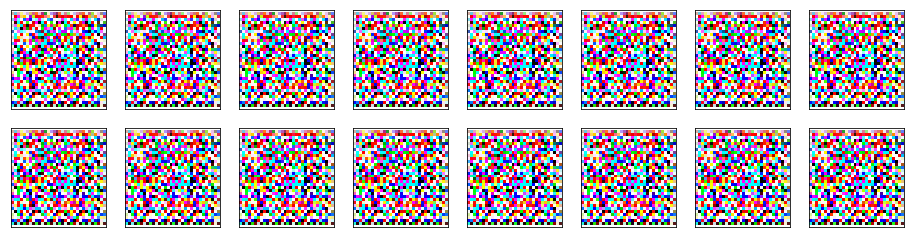

In [16]:
run_all(batch_size = 16, 
        img_size = 32, 
        d_conv_dim = 32 ,
        g_conv_dim = 32,
        z_size = 100,
        lr = 0.001, b1=0.5, b2=0.999,
        n_epochs = 30)

Training on GPU!
Number of images:  89931
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=1024, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=1024, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), 

Epoch [    2/   20] | d_loss: 0.4493 | g_loss: 0.3270
Epoch [    2/   20] | d_loss: 0.4564 | g_loss: 0.3184
Epoch [    2/   20] | d_loss: 0.4813 | g_loss: 0.3120
Epoch [    2/   20] | d_loss: 0.4685 | g_loss: 0.3182
Epoch [    2/   20] | d_loss: 0.4447 | g_loss: 0.3367
Epoch [    2/   20] | d_loss: 0.4593 | g_loss: 0.3170
Epoch [    2/   20] | d_loss: 0.4641 | g_loss: 0.3151
Epoch [    2/   20] | d_loss: 0.4516 | g_loss: 0.3285
Epoch [    2/   20] | d_loss: 0.4524 | g_loss: 0.3423
Epoch [    2/   20] | d_loss: 0.4535 | g_loss: 0.3230
Epoch [    2/   20] | d_loss: 0.4435 | g_loss: 0.3330
Epoch [    2/   20] | d_loss: 0.4674 | g_loss: 0.3177
Epoch [    2/   20] | d_loss: 0.4548 | g_loss: 0.3343
Epoch [    2/   20] | d_loss: 0.4521 | g_loss: 0.3241
Epoch [    2/   20] | d_loss: 0.4666 | g_loss: 0.3011
Epoch [    2/   20] | d_loss: 0.4588 | g_loss: 0.3058
Epoch [    2/   20] | d_loss: 0.4574 | g_loss: 0.3222
Epoch [    2/   20] | d_loss: 0.4414 | g_loss: 0.3310
Epoch [    2/   20] | d_loss

Epoch [    3/   20] | d_loss: 0.4383 | g_loss: 0.2990
Epoch [    3/   20] | d_loss: 0.4455 | g_loss: 0.3801
Epoch [    3/   20] | d_loss: 0.4500 | g_loss: 0.3406
Epoch [    3/   20] | d_loss: 0.4401 | g_loss: 0.3159
Epoch [    3/   20] | d_loss: 0.4311 | g_loss: 0.3339
Epoch [    3/   20] | d_loss: 0.4387 | g_loss: 0.3222
Epoch [    3/   20] | d_loss: 0.4341 | g_loss: 0.3477
Epoch [    3/   20] | d_loss: 0.4521 | g_loss: 0.3522
Epoch [    3/   20] | d_loss: 0.4336 | g_loss: 0.3415
Epoch [    3/   20] | d_loss: 0.4459 | g_loss: 0.3189
Epoch [    3/   20] | d_loss: 0.4505 | g_loss: 0.3219
Epoch [    3/   20] | d_loss: 0.4364 | g_loss: 0.3095
Epoch [    3/   20] | d_loss: 0.4447 | g_loss: 0.3243
Epoch [    3/   20] | d_loss: 0.4310 | g_loss: 0.3559
Epoch [    3/   20] | d_loss: 0.4388 | g_loss: 0.3445
Epoch [    3/   20] | d_loss: 0.4261 | g_loss: 0.3514
Epoch [    3/   20] | d_loss: 0.4265 | g_loss: 0.3287
Epoch [    3/   20] | d_loss: 0.4603 | g_loss: 0.3433
Epoch [    3/   20] | d_loss

Epoch [    4/   20] | d_loss: 0.4432 | g_loss: 0.3499
Epoch [    4/   20] | d_loss: 0.4422 | g_loss: 0.3381
Epoch [    4/   20] | d_loss: 0.4362 | g_loss: 0.3556
Epoch [    4/   20] | d_loss: 0.4219 | g_loss: 0.3801
Epoch [    4/   20] | d_loss: 0.4263 | g_loss: 0.3245
Epoch [    4/   20] | d_loss: 0.4275 | g_loss: 0.3553
Epoch [    4/   20] | d_loss: 0.4366 | g_loss: 0.3539
Epoch [    4/   20] | d_loss: 0.4512 | g_loss: 0.3479
Epoch [    4/   20] | d_loss: 0.4386 | g_loss: 0.3230
Epoch [    4/   20] | d_loss: 0.4477 | g_loss: 0.3517
Epoch [    4/   20] | d_loss: 0.4282 | g_loss: 0.3244
Epoch [    4/   20] | d_loss: 0.4333 | g_loss: 0.3291
Epoch [    4/   20] | d_loss: 0.4544 | g_loss: 0.3688
Epoch [    4/   20] | d_loss: 0.4332 | g_loss: 0.3527
Epoch [    4/   20] | d_loss: 0.4343 | g_loss: 0.3515
Epoch [    4/   20] | d_loss: 0.4366 | g_loss: 0.3291
Epoch [    4/   20] | d_loss: 0.4241 | g_loss: 0.3365
Epoch [    4/   20] | d_loss: 0.4536 | g_loss: 0.3246
Epoch [    4/   20] | d_loss

Epoch [    6/   20] | d_loss: 0.4451 | g_loss: 0.3325
Epoch [    6/   20] | d_loss: 0.4502 | g_loss: 0.3549
Epoch [    6/   20] | d_loss: 0.4429 | g_loss: 0.3703
Epoch [    6/   20] | d_loss: 0.4334 | g_loss: 0.3353
Epoch [    6/   20] | d_loss: 0.4247 | g_loss: 0.3427
Epoch [    6/   20] | d_loss: 0.4537 | g_loss: 0.3567
Epoch [    6/   20] | d_loss: 0.4398 | g_loss: 0.3418
Epoch [    6/   20] | d_loss: 0.4146 | g_loss: 0.3923
Epoch [    6/   20] | d_loss: 0.4139 | g_loss: 0.3430
Epoch [    6/   20] | d_loss: 0.4356 | g_loss: 0.4033
Epoch [    6/   20] | d_loss: 0.4278 | g_loss: 0.3661
Epoch [    6/   20] | d_loss: 0.4303 | g_loss: 0.4006
Epoch [    6/   20] | d_loss: 0.4161 | g_loss: 0.3690
Epoch [    6/   20] | d_loss: 0.4471 | g_loss: 0.3675
Epoch [    6/   20] | d_loss: 0.4314 | g_loss: 0.4056
Epoch [    6/   20] | d_loss: 0.4438 | g_loss: 0.3583
Epoch [    6/   20] | d_loss: 0.4296 | g_loss: 0.3986
Epoch [    6/   20] | d_loss: 0.4294 | g_loss: 0.3521
Epoch [    6/   20] | d_loss

Epoch [    7/   20] | d_loss: 0.4165 | g_loss: 0.3988
Epoch [    7/   20] | d_loss: 0.4193 | g_loss: 0.3836
Epoch [    7/   20] | d_loss: 0.4118 | g_loss: 0.4001
Epoch [    7/   20] | d_loss: 0.4247 | g_loss: 0.3621
Epoch [    7/   20] | d_loss: 0.4207 | g_loss: 0.3309
Epoch [    7/   20] | d_loss: 0.4307 | g_loss: 0.4054
Epoch [    7/   20] | d_loss: 0.4148 | g_loss: 0.3901
Epoch [    7/   20] | d_loss: 0.4416 | g_loss: 0.3805
Epoch [    7/   20] | d_loss: 0.4394 | g_loss: 0.3830
Epoch [    7/   20] | d_loss: 0.4255 | g_loss: 0.3647
Epoch [    7/   20] | d_loss: 0.4290 | g_loss: 0.3655
Epoch [    7/   20] | d_loss: 0.4186 | g_loss: 0.3940
Epoch [    7/   20] | d_loss: 0.4315 | g_loss: 0.3457
Epoch [    7/   20] | d_loss: 0.4410 | g_loss: 0.3700
Epoch [    7/   20] | d_loss: 0.4235 | g_loss: 0.3485
Epoch [    7/   20] | d_loss: 0.4262 | g_loss: 0.3395
Epoch [    7/   20] | d_loss: 0.4222 | g_loss: 0.3478
Epoch [    7/   20] | d_loss: 0.4330 | g_loss: 0.3756
Epoch [    7/   20] | d_loss

Epoch [    8/   20] | d_loss: 0.4513 | g_loss: 0.3060
Epoch [    8/   20] | d_loss: 0.4285 | g_loss: 0.3416
Epoch [    8/   20] | d_loss: 0.4173 | g_loss: 0.3765
Epoch [    8/   20] | d_loss: 0.4070 | g_loss: 0.4168
Epoch [    8/   20] | d_loss: 0.4486 | g_loss: 0.3693
Epoch [    8/   20] | d_loss: 0.4214 | g_loss: 0.4012
Epoch [    8/   20] | d_loss: 0.4355 | g_loss: 0.3482
Epoch [    8/   20] | d_loss: 0.4215 | g_loss: 0.3530
Epoch [    8/   20] | d_loss: 0.4283 | g_loss: 0.3958
Epoch [    8/   20] | d_loss: 0.4465 | g_loss: 0.3378
Epoch [    8/   20] | d_loss: 0.4217 | g_loss: 0.3890
Epoch [    8/   20] | d_loss: 0.4449 | g_loss: 0.3416
Epoch [    8/   20] | d_loss: 0.4332 | g_loss: 0.3901
Epoch [    8/   20] | d_loss: 0.5087 | g_loss: 0.3797
Epoch [    8/   20] | d_loss: 0.4369 | g_loss: 0.3924
Epoch [    8/   20] | d_loss: 0.4127 | g_loss: 0.3457
Epoch [    8/   20] | d_loss: 0.4293 | g_loss: 0.3355
Epoch [    8/   20] | d_loss: 0.4164 | g_loss: 0.3770
Epoch [    8/   20] | d_loss

Epoch [   10/   20] | d_loss: 0.4057 | g_loss: 0.4102
Epoch [   10/   20] | d_loss: 0.4060 | g_loss: 0.3855
Epoch [   10/   20] | d_loss: 0.4096 | g_loss: 0.3986
Epoch [   10/   20] | d_loss: 0.4067 | g_loss: 0.4112
Epoch [   10/   20] | d_loss: 0.4114 | g_loss: 0.3818
Epoch [   10/   20] | d_loss: 0.4045 | g_loss: 0.4085
Epoch [   10/   20] | d_loss: 0.4093 | g_loss: 0.4219
Epoch [   10/   20] | d_loss: 0.4030 | g_loss: 0.3974
Epoch [   10/   20] | d_loss: 0.4064 | g_loss: 0.3958
Epoch [   10/   20] | d_loss: 0.4053 | g_loss: 0.4151
Epoch [   10/   20] | d_loss: 0.4154 | g_loss: 0.3642
Epoch [   10/   20] | d_loss: 0.4044 | g_loss: 0.4043
Epoch [   10/   20] | d_loss: 0.4129 | g_loss: 0.3706
Epoch [   10/   20] | d_loss: 0.4117 | g_loss: 0.4102
Epoch [   10/   20] | d_loss: 0.4073 | g_loss: 0.4009
Epoch [   10/   20] | d_loss: 0.4065 | g_loss: 0.4075
Epoch [   10/   20] | d_loss: 0.4090 | g_loss: 0.4104
Epoch [   10/   20] | d_loss: 0.4031 | g_loss: 0.4018
Epoch [   10/   20] | d_loss

Epoch [   11/   20] | d_loss: 0.4046 | g_loss: 0.3969
Epoch [   11/   20] | d_loss: 0.4192 | g_loss: 0.3888
Epoch [   11/   20] | d_loss: 0.4129 | g_loss: 0.3858
Epoch [   11/   20] | d_loss: 0.4395 | g_loss: 0.3281
Epoch [   11/   20] | d_loss: 0.4052 | g_loss: 0.4237
Epoch [   11/   20] | d_loss: 0.4084 | g_loss: 0.4184
Epoch [   11/   20] | d_loss: 0.4010 | g_loss: 0.4176
Epoch [   11/   20] | d_loss: 0.4327 | g_loss: 0.3762
Epoch [   11/   20] | d_loss: 0.4020 | g_loss: 0.4148
Epoch [   11/   20] | d_loss: 0.4063 | g_loss: 0.4174
Epoch [   11/   20] | d_loss: 0.4096 | g_loss: 0.4050
Epoch [   11/   20] | d_loss: 0.4111 | g_loss: 0.4034
Epoch [   11/   20] | d_loss: 0.4051 | g_loss: 0.4106
Epoch [   11/   20] | d_loss: 0.4053 | g_loss: 0.4124
Epoch [   11/   20] | d_loss: 0.4022 | g_loss: 0.3948
Epoch [   11/   20] | d_loss: 0.4025 | g_loss: 0.4100
Epoch [   11/   20] | d_loss: 0.4027 | g_loss: 0.3897
Epoch [   11/   20] | d_loss: 0.4059 | g_loss: 0.3966
Epoch [   11/   20] | d_loss

Epoch [   12/   20] | d_loss: 0.4241 | g_loss: 0.3697
Epoch [   12/   20] | d_loss: 0.4275 | g_loss: 0.3620
Epoch [   12/   20] | d_loss: 0.4330 | g_loss: 0.3607
Epoch [   12/   20] | d_loss: 0.4657 | g_loss: 0.3460
Epoch [   12/   20] | d_loss: 0.4160 | g_loss: 0.4052
Epoch [   12/   20] | d_loss: 0.4282 | g_loss: 0.3968
Epoch [   12/   20] | d_loss: 0.4471 | g_loss: 0.3513
Epoch [   12/   20] | d_loss: 0.4259 | g_loss: 0.3622
Epoch [   12/   20] | d_loss: 0.4489 | g_loss: 0.3668
Epoch [   12/   20] | d_loss: 0.4605 | g_loss: 0.4098
Epoch [   12/   20] | d_loss: 0.4329 | g_loss: 0.3790
Epoch [   12/   20] | d_loss: 0.4207 | g_loss: 0.3805
Epoch [   12/   20] | d_loss: 0.4295 | g_loss: 0.3576
Epoch [   12/   20] | d_loss: 0.4288 | g_loss: 0.3480
Epoch [   12/   20] | d_loss: 0.4269 | g_loss: 0.3546
Epoch [   12/   20] | d_loss: 0.4339 | g_loss: 0.3930
Epoch [   12/   20] | d_loss: 0.4382 | g_loss: 0.3521
Epoch [   12/   20] | d_loss: 0.4493 | g_loss: 0.3656
Epoch [   12/   20] | d_loss

Epoch [   14/   20] | d_loss: 0.4053 | g_loss: 0.3569
Epoch [   14/   20] | d_loss: 0.4066 | g_loss: 0.3579
Epoch [   14/   20] | d_loss: 0.4079 | g_loss: 0.3580
Epoch [   14/   20] | d_loss: 0.4059 | g_loss: 0.3569
Epoch [   14/   20] | d_loss: 0.4095 | g_loss: 0.3587
Epoch [   14/   20] | d_loss: 0.4064 | g_loss: 0.3588
Epoch [   14/   20] | d_loss: 0.4068 | g_loss: 0.3583
Epoch [   14/   20] | d_loss: 0.4106 | g_loss: 0.3614
Epoch [   14/   20] | d_loss: 0.4114 | g_loss: 0.3637
Epoch [   14/   20] | d_loss: 0.4122 | g_loss: 0.3611
Epoch [   14/   20] | d_loss: 0.4067 | g_loss: 0.3609
Epoch [   14/   20] | d_loss: 0.4065 | g_loss: 0.3583
Epoch [   14/   20] | d_loss: 0.4179 | g_loss: 0.3575
Epoch [   14/   20] | d_loss: 0.4060 | g_loss: 0.3564
Epoch [   14/   20] | d_loss: 0.4052 | g_loss: 0.3568
Epoch [   14/   20] | d_loss: 0.4063 | g_loss: 0.3591
Epoch [   14/   20] | d_loss: 0.4054 | g_loss: 0.3572
Epoch [   14/   20] | d_loss: 0.4076 | g_loss: 0.3596
Epoch [   14/   20] | d_loss

Epoch [   15/   20] | d_loss: 0.3979 | g_loss: 0.3559
Epoch [   15/   20] | d_loss: 0.4003 | g_loss: 0.3583
Epoch [   15/   20] | d_loss: 0.3950 | g_loss: 0.3573
Epoch [   15/   20] | d_loss: 0.4021 | g_loss: 0.3529
Epoch [   15/   20] | d_loss: 0.3961 | g_loss: 0.3510
Epoch [   15/   20] | d_loss: 0.3979 | g_loss: 0.3538
Epoch [   15/   20] | d_loss: 0.3951 | g_loss: 0.3574
Epoch [   15/   20] | d_loss: 0.3980 | g_loss: 0.3589
Epoch [   15/   20] | d_loss: 0.4039 | g_loss: 0.3597
Epoch [   15/   20] | d_loss: 0.3956 | g_loss: 0.3590
Epoch [   15/   20] | d_loss: 0.3969 | g_loss: 0.3626
Epoch [   15/   20] | d_loss: 0.3953 | g_loss: 0.3631
Epoch [   15/   20] | d_loss: 0.3976 | g_loss: 0.3602
Epoch [   15/   20] | d_loss: 0.3970 | g_loss: 0.3611
Epoch [   15/   20] | d_loss: 0.3978 | g_loss: 0.3607
Epoch [   15/   20] | d_loss: 0.3957 | g_loss: 0.3618
Epoch [   15/   20] | d_loss: 0.3998 | g_loss: 0.3590
Epoch [   15/   20] | d_loss: 0.3965 | g_loss: 0.3544
Epoch [   15/   20] | d_loss

Epoch [   16/   20] | d_loss: 0.3959 | g_loss: 0.3590
Epoch [   16/   20] | d_loss: 0.3973 | g_loss: 0.3581
Epoch [   16/   20] | d_loss: 0.3953 | g_loss: 0.3570
Epoch [   16/   20] | d_loss: 0.3953 | g_loss: 0.3577
Epoch [   16/   20] | d_loss: 0.3999 | g_loss: 0.3578
Epoch [   16/   20] | d_loss: 0.3953 | g_loss: 0.3577
Epoch [   16/   20] | d_loss: 0.4060 | g_loss: 0.3575
Epoch [   16/   20] | d_loss: 0.3934 | g_loss: 0.3599
Epoch [   16/   20] | d_loss: 0.3941 | g_loss: 0.3620
Epoch [   16/   20] | d_loss: 0.3945 | g_loss: 0.3623
Epoch [   16/   20] | d_loss: 0.3952 | g_loss: 0.3599
Epoch [   16/   20] | d_loss: 0.4092 | g_loss: 0.3580
Epoch [   16/   20] | d_loss: 0.3955 | g_loss: 0.3555
Epoch [   16/   20] | d_loss: 0.3954 | g_loss: 0.3555
Epoch [   16/   20] | d_loss: 0.3965 | g_loss: 0.3593
Epoch [   17/   20] | d_loss: 0.4066 | g_loss: 0.3588
Epoch [   17/   20] | d_loss: 0.3957 | g_loss: 0.3585
Epoch [   17/   20] | d_loss: 0.3933 | g_loss: 0.3576
Epoch [   17/   20] | d_loss

Epoch [   18/   20] | d_loss: 0.3946 | g_loss: 0.3667
Epoch [   18/   20] | d_loss: 0.3951 | g_loss: 0.3651
Epoch [   18/   20] | d_loss: 0.3928 | g_loss: 0.3643
Epoch [   18/   20] | d_loss: 0.3926 | g_loss: 0.3652
Epoch [   18/   20] | d_loss: 0.3933 | g_loss: 0.3637
Epoch [   18/   20] | d_loss: 0.4005 | g_loss: 0.3644
Epoch [   18/   20] | d_loss: 0.3981 | g_loss: 0.3678
Epoch [   18/   20] | d_loss: 0.3953 | g_loss: 0.3637
Epoch [   18/   20] | d_loss: 0.3944 | g_loss: 0.3625
Epoch [   18/   20] | d_loss: 0.3976 | g_loss: 0.3613
Epoch [   18/   20] | d_loss: 0.4033 | g_loss: 0.3580
Epoch [   18/   20] | d_loss: 0.4032 | g_loss: 0.3586
Epoch [   18/   20] | d_loss: 0.3974 | g_loss: 0.3613
Epoch [   18/   20] | d_loss: 0.3929 | g_loss: 0.3584
Epoch [   18/   20] | d_loss: 0.3936 | g_loss: 0.3530
Epoch [   18/   20] | d_loss: 0.3958 | g_loss: 0.3526
Epoch [   18/   20] | d_loss: 0.3999 | g_loss: 0.3525
Epoch [   18/   20] | d_loss: 0.3932 | g_loss: 0.3537
Epoch [   18/   20] | d_loss

Epoch [   19/   20] | d_loss: 0.3997 | g_loss: 0.3635
Epoch [   19/   20] | d_loss: 0.3956 | g_loss: 0.3628
Epoch [   19/   20] | d_loss: 0.3929 | g_loss: 0.3623
Epoch [   19/   20] | d_loss: 0.4047 | g_loss: 0.3633
Epoch [   19/   20] | d_loss: 0.3955 | g_loss: 0.3646
Epoch [   19/   20] | d_loss: 0.3930 | g_loss: 0.3623
Epoch [   19/   20] | d_loss: 0.3940 | g_loss: 0.3646
Epoch [   19/   20] | d_loss: 0.3935 | g_loss: 0.3672
Epoch [   19/   20] | d_loss: 0.4049 | g_loss: 0.3681
Epoch [   19/   20] | d_loss: 0.3958 | g_loss: 0.3678
Epoch [   19/   20] | d_loss: 0.3924 | g_loss: 0.3657
Epoch [   19/   20] | d_loss: 0.3968 | g_loss: 0.3657
Epoch [   19/   20] | d_loss: 0.3956 | g_loss: 0.3666
Epoch [   19/   20] | d_loss: 0.4029 | g_loss: 0.3663
Epoch [   19/   20] | d_loss: 0.3922 | g_loss: 0.3695
Epoch [   19/   20] | d_loss: 0.3957 | g_loss: 0.3670
Epoch [   19/   20] | d_loss: 0.3923 | g_loss: 0.3648
Epoch [   19/   20] | d_loss: 0.3929 | g_loss: 0.3632
Epoch [   19/   20] | d_loss

Epoch [   20/   20] | d_loss: 0.3961 | g_loss: 0.3701
Epoch [   20/   20] | d_loss: 0.3923 | g_loss: 0.3703
Epoch [   20/   20] | d_loss: 0.3939 | g_loss: 0.3708
Epoch [   20/   20] | d_loss: 0.3922 | g_loss: 0.3704
Epoch [   20/   20] | d_loss: 0.3959 | g_loss: 0.3709
Epoch [   20/   20] | d_loss: 0.3958 | g_loss: 0.3700
Epoch [   20/   20] | d_loss: 0.3964 | g_loss: 0.3652
Epoch [   20/   20] | d_loss: 0.3936 | g_loss: 0.3626
Epoch [   20/   20] | d_loss: 0.3930 | g_loss: 0.3641
Epoch [   20/   20] | d_loss: 0.3925 | g_loss: 0.3652
Epoch [   20/   20] | d_loss: 0.4022 | g_loss: 0.3653


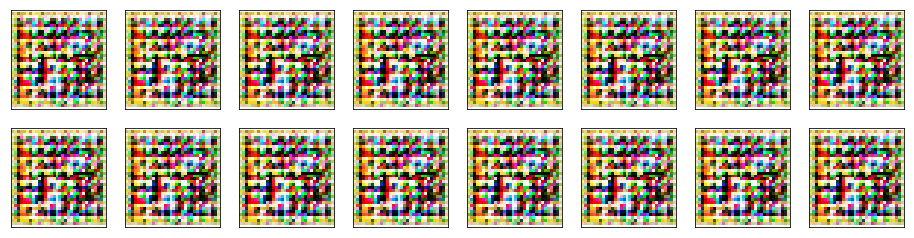

In [17]:
run_all(batch_size = 16, 
        img_size = 32, 
        d_conv_dim = 32 ,
        g_conv_dim = 32,
        z_size = 100,
        lr = 0.0005, b1=0.5, b2=0.999,
        n_epochs = 20)

Training on GPU!
Number of images:  89931
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=1024, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=1024, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), 

Epoch [    9/   20] | d_loss: 0.4108 | g_loss: 0.4390
Epoch [    9/   20] | d_loss: 0.4102 | g_loss: 0.4400
Epoch [    9/   20] | d_loss: 0.4102 | g_loss: 0.4401
Epoch [    9/   20] | d_loss: 0.4100 | g_loss: 0.4400
Epoch [    9/   20] | d_loss: 0.4100 | g_loss: 0.4402
Epoch [    9/   20] | d_loss: 0.4097 | g_loss: 0.4417
Epoch [    9/   20] | d_loss: 0.4108 | g_loss: 0.4408
Epoch [    9/   20] | d_loss: 0.4395 | g_loss: 0.4396
Epoch [    9/   20] | d_loss: 0.4133 | g_loss: 0.4431
Epoch [    9/   20] | d_loss: 0.4111 | g_loss: 0.4439
Epoch [    9/   20] | d_loss: 0.4116 | g_loss: 0.4458
Epoch [    9/   20] | d_loss: 0.4115 | g_loss: 0.4502
Epoch [    9/   20] | d_loss: 0.4102 | g_loss: 0.4474
Epoch [    9/   20] | d_loss: 0.4111 | g_loss: 0.4461
Epoch [   10/   20] | d_loss: 0.4169 | g_loss: 0.4498
Epoch [   10/   20] | d_loss: 0.4129 | g_loss: 0.4483
Epoch [   10/   20] | d_loss: 0.4118 | g_loss: 0.4554
Epoch [   10/   20] | d_loss: 0.4956 | g_loss: 0.4044
Epoch [   10/   20] | d_loss

Epoch [   19/   20] | d_loss: 0.4478 | g_loss: 0.3814
Epoch [   19/   20] | d_loss: 0.4674 | g_loss: 0.4444
Epoch [   19/   20] | d_loss: 0.4450 | g_loss: 0.4647
Epoch [   19/   20] | d_loss: 0.4658 | g_loss: 0.4032
Epoch [   19/   20] | d_loss: 0.4565 | g_loss: 0.3977
Epoch [   19/   20] | d_loss: 0.4451 | g_loss: 0.4236
Epoch [   19/   20] | d_loss: 0.4388 | g_loss: 0.4464
Epoch [   19/   20] | d_loss: 0.4904 | g_loss: 0.3589
Epoch [   19/   20] | d_loss: 0.4385 | g_loss: 0.4486
Epoch [   19/   20] | d_loss: 0.4491 | g_loss: 0.4128
Epoch [   19/   20] | d_loss: 0.4569 | g_loss: 0.4402
Epoch [   19/   20] | d_loss: 0.4525 | g_loss: 0.4384
Epoch [   20/   20] | d_loss: 0.4688 | g_loss: 0.3893
Epoch [   20/   20] | d_loss: 0.4393 | g_loss: 0.4698
Epoch [   20/   20] | d_loss: 0.4491 | g_loss: 0.4131
Epoch [   20/   20] | d_loss: 0.4816 | g_loss: 0.4334
Epoch [   20/   20] | d_loss: 0.4482 | g_loss: 0.4522
Epoch [   20/   20] | d_loss: 0.4447 | g_loss: 0.4123
Epoch [   20/   20] | d_loss

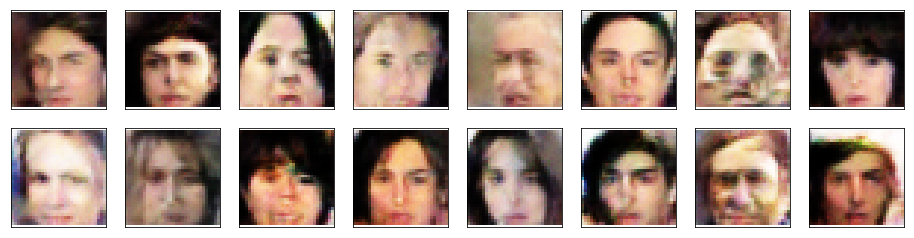

In [18]:
run_all(batch_size = 128, 
        img_size = 32, 
        d_conv_dim = 32 ,
        g_conv_dim = 32,
        z_size = 100,
        lr = 0.0005, b1=0.5, b2=0.999,
        n_epochs = 20)

Training on GPU!
Number of images:  89931
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=1024, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=1024, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), 

Epoch [   16/   20] | d_loss: 0.4524 | g_loss: 0.3852
Epoch [   16/   20] | d_loss: 0.4521 | g_loss: 0.3927
Epoch [   16/   20] | d_loss: 0.4534 | g_loss: 0.4113
Epoch [   16/   20] | d_loss: 0.4542 | g_loss: 0.4067
Epoch [   16/   20] | d_loss: 0.4507 | g_loss: 0.3612
Epoch [   16/   20] | d_loss: 0.4613 | g_loss: 0.3887
Epoch [   16/   20] | d_loss: 0.4557 | g_loss: 0.3667
Epoch [   17/   20] | d_loss: 0.4741 | g_loss: 0.3612
Epoch [   17/   20] | d_loss: 0.4570 | g_loss: 0.4203
Epoch [   17/   20] | d_loss: 0.4516 | g_loss: 0.3710
Epoch [   17/   20] | d_loss: 0.4478 | g_loss: 0.4277
Epoch [   17/   20] | d_loss: 0.4480 | g_loss: 0.4064
Epoch [   17/   20] | d_loss: 0.4685 | g_loss: 0.4341
Epoch [   17/   20] | d_loss: 0.4511 | g_loss: 0.4263
Epoch [   17/   20] | d_loss: 0.4513 | g_loss: 0.4253
Epoch [   18/   20] | d_loss: 0.4510 | g_loss: 0.4164
Epoch [   18/   20] | d_loss: 0.4496 | g_loss: 0.4166
Epoch [   18/   20] | d_loss: 0.4621 | g_loss: 0.4341
Epoch [   18/   20] | d_loss

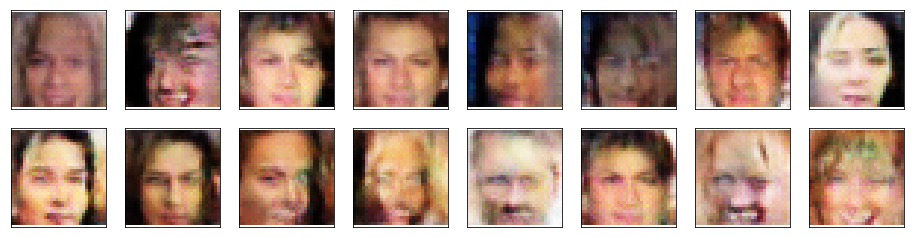

In [20]:
# 
run_all(batch_size = 256, 
        img_size = 32, 
        d_conv_dim = 32 ,
        g_conv_dim = 32,
        z_size = 100,
        lr = 0.001, b1=0.5, b2=0.999,
        n_epochs = 20)

Training on GPU!
Number of images:  89931
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=1024, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=1024, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), 

Epoch [    9/   20] | d_loss: 0.4057 | g_loss: 0.4790
Epoch [    9/   20] | d_loss: 0.4046 | g_loss: 0.4817
Epoch [    9/   20] | d_loss: 0.4068 | g_loss: 0.4799
Epoch [    9/   20] | d_loss: 0.4046 | g_loss: 0.4806
Epoch [    9/   20] | d_loss: 0.4032 | g_loss: 0.4819
Epoch [    9/   20] | d_loss: 0.4030 | g_loss: 0.4812
Epoch [    9/   20] | d_loss: 0.4059 | g_loss: 0.4826
Epoch [    9/   20] | d_loss: 0.4043 | g_loss: 0.4841
Epoch [    9/   20] | d_loss: 0.4025 | g_loss: 0.4828
Epoch [    9/   20] | d_loss: 0.4063 | g_loss: 0.4849
Epoch [    9/   20] | d_loss: 0.4021 | g_loss: 0.4845
Epoch [    9/   20] | d_loss: 0.4024 | g_loss: 0.4850
Epoch [    9/   20] | d_loss: 0.4016 | g_loss: 0.4870
Epoch [    9/   20] | d_loss: 0.4007 | g_loss: 0.4872
Epoch [   10/   20] | d_loss: 0.4010 | g_loss: 0.4876
Epoch [   10/   20] | d_loss: 0.4011 | g_loss: 0.4891
Epoch [   10/   20] | d_loss: 0.4019 | g_loss: 0.4885
Epoch [   10/   20] | d_loss: 0.4012 | g_loss: 0.4864
Epoch [   10/   20] | d_loss

Epoch [   19/   20] | d_loss: 0.3880 | g_loss: 0.5251
Epoch [   19/   20] | d_loss: 0.3894 | g_loss: 0.5250
Epoch [   19/   20] | d_loss: 0.3903 | g_loss: 0.5258
Epoch [   19/   20] | d_loss: 0.3878 | g_loss: 0.5253
Epoch [   19/   20] | d_loss: 0.3872 | g_loss: 0.5261
Epoch [   19/   20] | d_loss: 0.3869 | g_loss: 0.5264
Epoch [   19/   20] | d_loss: 0.3878 | g_loss: 0.5270
Epoch [   19/   20] | d_loss: 0.3899 | g_loss: 0.5256
Epoch [   19/   20] | d_loss: 0.3870 | g_loss: 0.5253
Epoch [   19/   20] | d_loss: 0.3907 | g_loss: 0.5253
Epoch [   19/   20] | d_loss: 0.3892 | g_loss: 0.5264
Epoch [   19/   20] | d_loss: 0.3868 | g_loss: 0.5284
Epoch [   20/   20] | d_loss: 0.3900 | g_loss: 0.5296
Epoch [   20/   20] | d_loss: 0.3871 | g_loss: 0.5263
Epoch [   20/   20] | d_loss: 0.3866 | g_loss: 0.5258
Epoch [   20/   20] | d_loss: 0.3881 | g_loss: 0.5252
Epoch [   20/   20] | d_loss: 0.3867 | g_loss: 0.5261
Epoch [   20/   20] | d_loss: 0.3892 | g_loss: 0.5269
Epoch [   20/   20] | d_loss

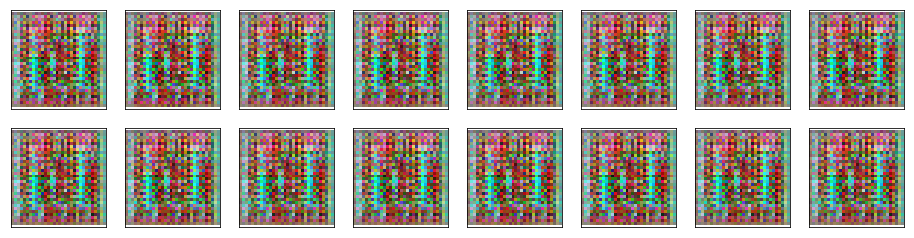

In [21]:
run_all(batch_size = 128, 
        img_size = 64, 
        d_conv_dim = 32 ,
        g_conv_dim = 32,
        z_size = 100,
        lr = 0.0005, b1=0.5, b2=0.999,
        n_epochs = 20)